# About Dataset

## CONTEXT
The market for used and refurbished devices has expanded significantly over the past ten years as a result of the availability of affordable options to consumers and businesses seeking to save costs when making a purchase. Increasing a device's lifespan through used-goods trading also lessens its influence on the environment, aids in recycling, and decreases waste. Here is a sample dataset of prices for new and used equipment that have been reconditioned or used.

## OBJECTIVE  
The objective is to do Exploratory Data Analytics and apply Linear Regression to create a model which can help in pricing of such devices. 
## Variables  
__device_brand__: Name of manufacturing brand  
__os__: OS on which the device runs  
__screen_size__: Size of the screen in cm  
__4g__: Whether 4G is available or not  
__5g__: Whether 5G is available or not  
__front_camera_mp__: Resolution of the rear camera in megapixels  
__back_camera_mp__: Resolution of the front camera in megapixels  
__internal_memory__: Amount of internal memory (ROM) in GB  
__ram__: Amount of RAM in GB  
__battery__: Energy capacity of the device battery in mAh  
__weight__: Weight of the device in grams  
__release_year__: Year when the device model was released  
__days_used__: Number of days the used/refurbished device has been used  
__normalized_new_price__: Normalized price of a new device of the same model  
__normalized_used_price (TARGET)__: Normalized price of the used/refurbished device  

# Importing libraries

In [1]:
import pandas as pd
pd.options.display.max_columns=None
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm, boxcox
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import csv
import psycopg2
import pickle as pk

# Connecting PostgreSQL with Python

In [2]:
conn = psycopg2.connect(dbname="test", user="postgres",password="DSB18082001*",port=5432)
cursor = conn.cursor()
conn.commit()

In [3]:
cursor.execute('drop table if exists used_device_data')
sql = '''CREATE TABLE used_device_data(device_brand varchar(20),\
os varchar(20),\
screen_size numeric,\
"4g" varchar(20),\
"5g" varchar(20),\
rear_camera_mp float,\
front_camera_mp float,\
internal_memory float,\
ram float,\
battery float,\
weight float,\
release_year int,\
days_used int,\
normalized_used_price float,\
normalized_new_price float);'''
cursor.execute(sql)
conn.commit()

In [4]:
df=pd.read_csv(r'C:\Users\divya\Documents\Used_phone_predictor\used_device_data.csv')

In [5]:
for i in df.index:
    vals=[df.at[i,col] for col in list(df.columns)]
    query="insert into used_device_data values('%s','%s','%s','%s','%s','%s','%s','%s','%s','%s','%s','%s','%s','%s','%s')" %(vals[0],vals[1],vals[2],vals[3],vals[4],vals[5],vals[6],vals[7],vals[8],vals[9],vals[10],vals[11],vals[12],vals[13],vals[14])
    
    cursor.execute(query)

conn.commit()

# Getting data

In [6]:
data=pd.read_sql('select * from used_device_data',con=conn)

In [7]:
conn.close()

# Initial Review

In [8]:
data.head()

,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,Honor,Android,14.50,yes,no,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100
1,Honor,Android,17.30,yes,yes,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018
2,Honor,Android,16.69,yes,yes,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631
3,Honor,Android,25.50,yes,yes,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961
4,Honor,Android,15.32,yes,no,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3454 entries, 0 to 3453
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   device_brand           3454 non-null   object 
 1   os                     3454 non-null   object 
 2   screen_size            3454 non-null   float64
 3   4g                     3454 non-null   object 
 4   5g                     3454 non-null   object 
 5   rear_camera_mp         3275 non-null   float64
 6   front_camera_mp        3452 non-null   float64
 7   internal_memory        3450 non-null   float64
 8   ram                    3450 non-null   float64
 9   battery                3448 non-null   float64
 10  weight                 3447 non-null   float64
 11  release_year           3454 non-null   int64  
 12  days_used              3454 non-null   int64  
 13  normalized_used_price  3454 non-null   float64
 14  normalized_new_price   3454 non-null   float64
dtypes: f

In [10]:
data.describe()

,screen_size,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
count,3454.000000,3275.000000,3452.000000,3450.000000,3450.000000,3448.000000,3447.000000,3454.000000,3454.000000,3454.000000,3454.000000
mean,13.713115,9.460208,6.554229,54.573099,4.036122,3133.402697,182.751871,2015.965258,674.869716,4.364712,5.233107
std,3.805280,4.815461,6.970372,84.972371,1.365105,1299.682844,88.413228,2.298455,248.580166,0.588914,0.683637
min,5.080000,0.080000,0.000000,0.010000,0.020000,500.000000,69.000000,2013.000000,91.000000,1.536867,2.901422
25%,12.700000,5.000000,2.000000,16.000000,4.000000,2100.000000,142.000000,2014.000000,533.500000,4.033931,4.790342
50%,12.830000,8.000000,5.000000,32.000000,4.000000,3000.000000,160.000000,2015.500000,690.500000,4.405133,5.245892
75%,15.340000,13.000000,8.000000,64.000000,4.000000,4000.000000,185.000000,2018.000000,868.750000,4.755700,5.673718
max,30.710000,48.000000,32.000000,1024.000000,12.000000,9720.000000,855.000000,2020.000000,1094.000000,6.619433,7.847841


# Checking missing values

In [11]:
data.isnull().sum()

device_brand               0
os                         0
screen_size                0
4g                         0
5g                         0
rear_camera_mp           179
front_camera_mp            2
internal_memory            4
ram                        4
battery                    6
weight                     7
release_year               0
days_used                  0
normalized_used_price      0
normalized_new_price       0
dtype: int64

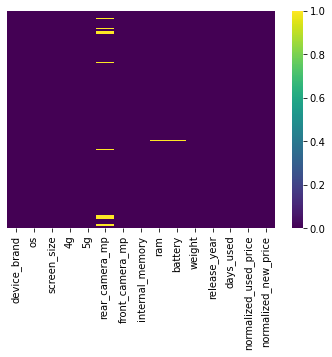

In [12]:
sns.heatmap(data.isnull(),yticklabels=False,cmap='viridis')
plt.show()

# Missing Values found

In [13]:
data=data.dropna()

In [14]:
data.shape

(3253, 15)

# Missing values dropped

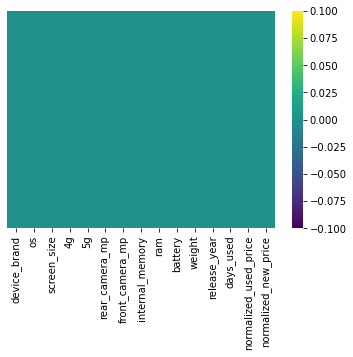

In [15]:
sns.heatmap(data.isnull(),yticklabels=False,cmap='viridis')
plt.show()

# Checking duplicate values

In [16]:
data.duplicated().sum()

0

# Encoding categorical features(4G,5G)

In [17]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
data['4g']=le.fit_transform(data['4g'])
data['5g']=le.fit_transform(data['5g'])

In [18]:
data.head()

,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,Honor,Android,14.50,1,0,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100
1,Honor,Android,17.30,1,1,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018
2,Honor,Android,16.69,1,1,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631
3,Honor,Android,25.50,1,1,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961
4,Honor,Android,15.32,1,0,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837


# Exploring categorical features

In [19]:
len(data.device_brand.value_counts())

33

In [20]:
data.device_brand.unique()

array(['Honor', 'Others', 'HTC', 'Huawei', 'Lava', 'Lenovo', 'LG',
       'Micromax', 'Nokia', 'Oppo', 'Samsung', 'Vivo', 'Xiaomi', 'ZTE',
       'Apple', 'Asus', 'Acer', 'Alcatel', 'BlackBerry', 'Celkon',
       'Coolpad', 'Gionee', 'Google', 'Karbonn', 'Meizu', 'Microsoft',
       'Motorola', 'OnePlus', 'Panasonic', 'Realme', 'Sony', 'Spice',
       'XOLO'], dtype=object)

In [21]:
brand_dict = data.groupby(['device_brand'])['normalized_used_price'].median().to_dict()
data['Device_Brand'] = data['device_brand'].map(brand_dict)

In [22]:
Max_brand = data['device_brand'].value_counts().sort_values(ascending=False)
Max_brand.name='Counts'
Max_brand.index.name = 'Brands'

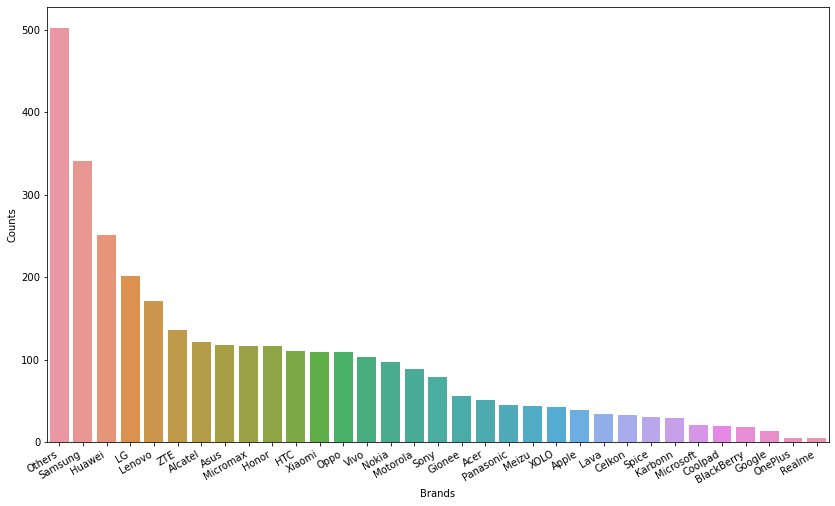

In [23]:
fig = plt.figure(figsize=(14,8))
ax=sns.barplot(x=Max_brand.index,y= Max_brand)
ax.set_xticklabels(Max_brand.index,rotation=30,ha='right')
plt.show()


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 [Text(0, 0, 'Honor'),
  Text(1, 0, 'Others'),
  Text(2, 0, 'HTC'),
  Text(3, 0, 'Huawei'),
  Text(4, 0, 'Lava'),
  Text(5, 0, 'Lenovo'),
  Text(6, 0, 'LG'),
  Text(7, 0, 'Micromax'),
  Text(8, 0, 'Nokia'),
  Text(9, 0, 'Oppo'),
  Text(10, 0, 'Samsung'),
  Text(11, 0, 'Vivo'),
  Text(12, 0, 'Xiaomi'),
  Text(13, 0, 'ZTE'),
  Text(14, 0, 'Apple'),
  Text(15, 0, 'Asus'),
  Text(16, 0, 'Acer'),
  Text(17, 0, 'Alcatel'),
  Text(18, 0, 'BlackBerry'),
  Text(19, 0, 'Celkon'),
  Text(20, 0, 'Coolpad'),
  Text(21, 0, 'Gionee'),
  Text(22, 0, 'Google'),
  Text(23, 0, 'Karbonn'),
  Text(24, 0, 'Meizu'),
  Text(25, 0, 'Microsoft'),
  Text(26, 0, 'Motorola'),
  Text(27, 0, 'OnePlus'),
  Text(28, 0, 'Panasonic'),
  Text(29, 0, 'Realme'),
  Text(30, 0, 'Sony'),
  Text(31, 0, 'Spice'),
  Text(32, 0, 'XOLO')])

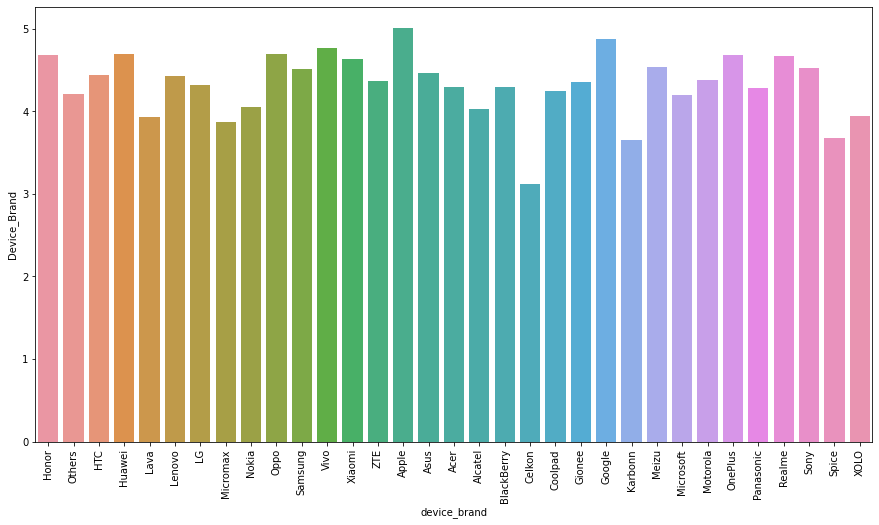

In [24]:
fig = plt.figure(figsize=(15,8))
sns.barplot(y=data['Device_Brand'],x=data['device_brand'])
plt.xticks(rotation=90)

In [25]:
data.os.value_counts()

Android    3024
Others      128
Windows      65
iOS          36
Name: os, dtype: int64

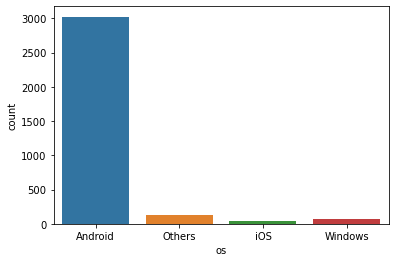

In [26]:
sns.countplot(data['os'])
plt.show()

### Android phones are highest in number

In [27]:
data['5g'].value_counts()

0    3168
1      85
Name: 5g, dtype: int64

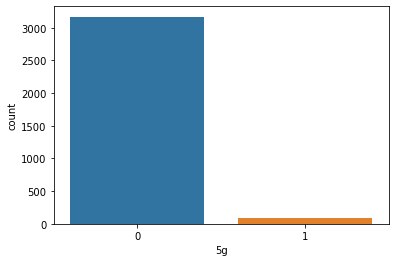

In [28]:
sns.countplot(data['5g'])
plt.show()

### There are fewer 5g phones

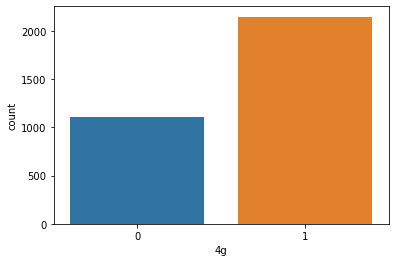

In [29]:
sns.countplot(data['4g'])
plt.show()

### There are more phones 4G enabled

In [30]:
data['ram'].value_counts()

4.00     2755
6.00      109
8.00       88
0.25       83
2.00       70
3.00       64
1.00       34
0.03       16
0.02       14
12.00      10
0.50        9
1.50        1
Name: ram, dtype: int64

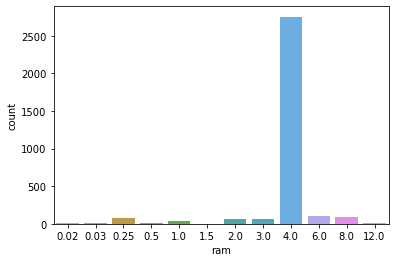

In [31]:
sns.countplot(data['ram'])
plt.show()

### Most phones have 4GB Ram

In [32]:
data['release_year'].value_counts()

2014    639
2013    567
2015    507
2019    399
2016    381
2018    310
2017    297
2020    153
Name: release_year, dtype: int64

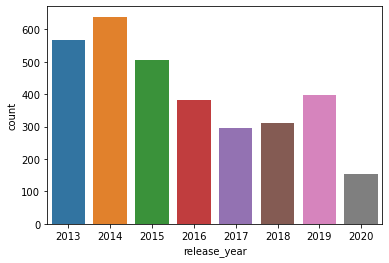

In [33]:
sns.countplot(data['release_year'])
plt.show()

### Most phones were released in the year 2014

In [34]:
data['internal_memory'].value_counts()

16.00      1278
32.00      1042
64.00       455
128.00      297
256.00       69
512.00       44
0.10         16
0.06         14
8.00         12
4.00         10
1024.00       8
0.50          4
0.20          2
24.00         1
0.01          1
Name: internal_memory, dtype: int64

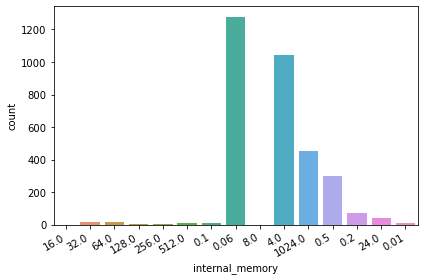

In [35]:
sns.countplot(data['internal_memory']).set_xticklabels(data['internal_memory'].value_counts().index,rotation=30,ha='right')
plt.tight_layout()


# Relation between target variable and categorical features

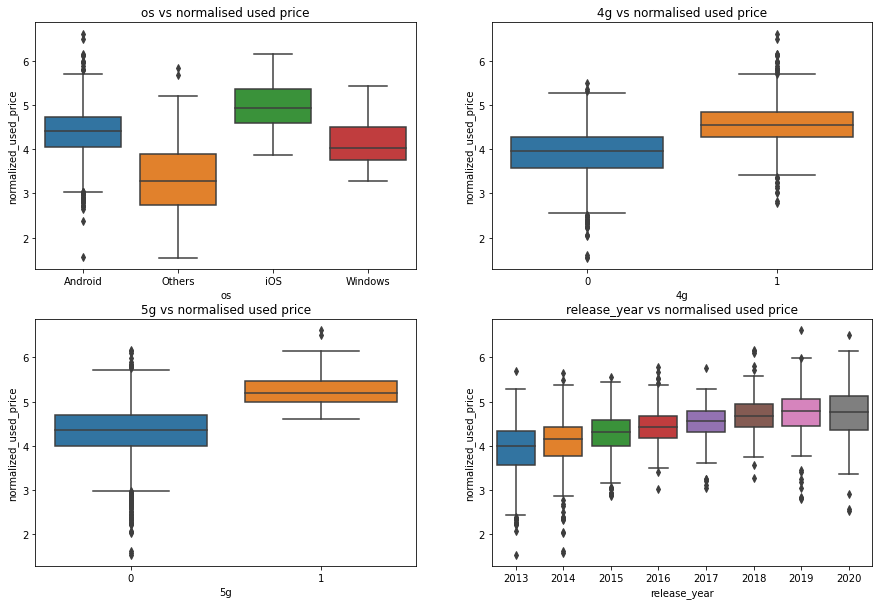

In [36]:
fig,ax = plt.subplots(2,2,figsize = (15,10))
sns.boxplot(x = 'os', y = 'normalized_used_price', data = data,ax=ax[0,0])
ax[0,0].set_title('os vs normalised used price')

sns.boxplot(x = '4g', y = 'normalized_used_price', data = data,ax=ax[0,1])
ax[0,1].set_title('4g vs normalised used price')

sns.boxplot(x = '5g', y = 'normalized_used_price', data = data,ax=ax[1,0])
ax[1,0].set_title('5g vs normalised used price')

sns.boxplot(x = 'release_year', y = 'normalized_used_price', data = data,ax=ax[1,1])
ax[1,1].set_title('release_year vs normalised used price')
plt.show()

## Through these visualizations we can see that :
- phones with os as ios are priced higher than phones with other os
- 5G enabled phones are priced higher
- 4G enabled phones are priced higher
- Phones from recent years are priced higher than phones from previous years

# Checking distribution of data

In [37]:
numerical_features = ['screen_size','rear_camera_mp','front_camera_mp','battery','weight','days_used','normalized_new_price', 'normalized_used_price']
numerical_features

['screen_size',
 'rear_camera_mp',
 'front_camera_mp',
 'battery',
 'weight',
 'days_used',
 'normalized_new_price',
 'normalized_used_price']

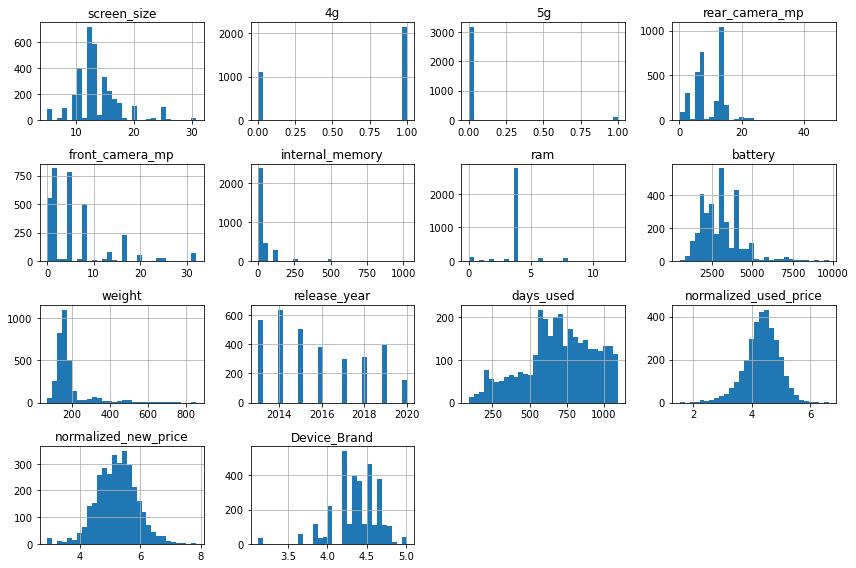

In [38]:
data.hist(figsize=(12,8),bins=30)
plt.tight_layout()

## Function to visualize relationship between target variable and numerical features

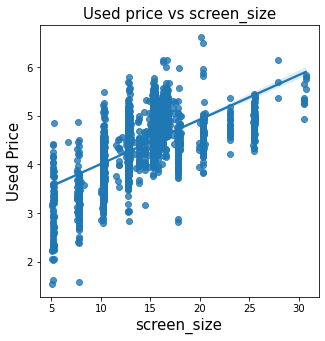

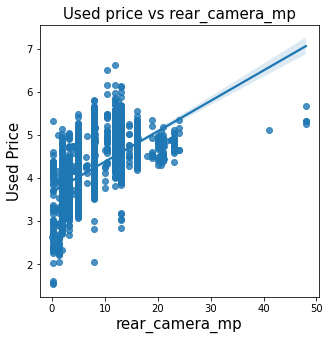

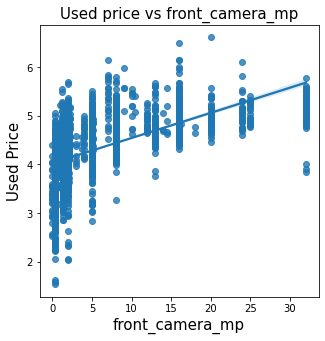

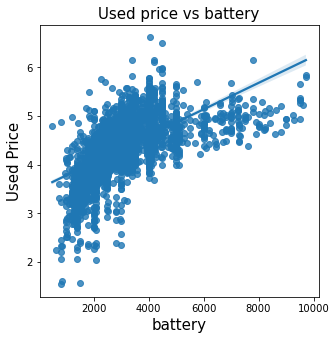

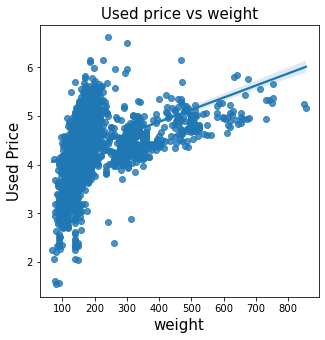

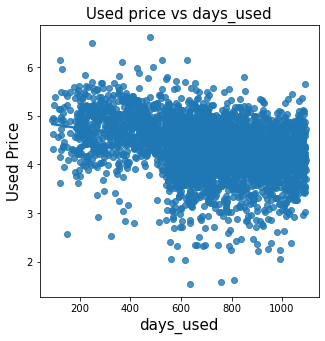

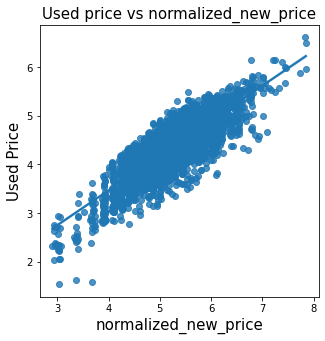

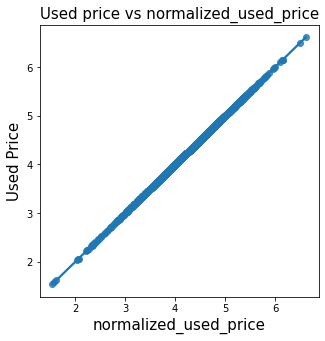

In [39]:
def bivariate_analysis(x):
    plt.figure(figsize=(5,5))
    ax=sns.regplot(x=x,y='normalized_used_price',data=data)
    ax.set_title("Used price vs "+x,fontsize=15)
    ax.set_xlabel(x,fontsize=15)
    ax.set_ylabel('Used Price',fontsize=15)
    plt.locator_params(axis='both')
    
for i in numerical_features:
    bivariate_analysis(i)

# Multivariate Analysis

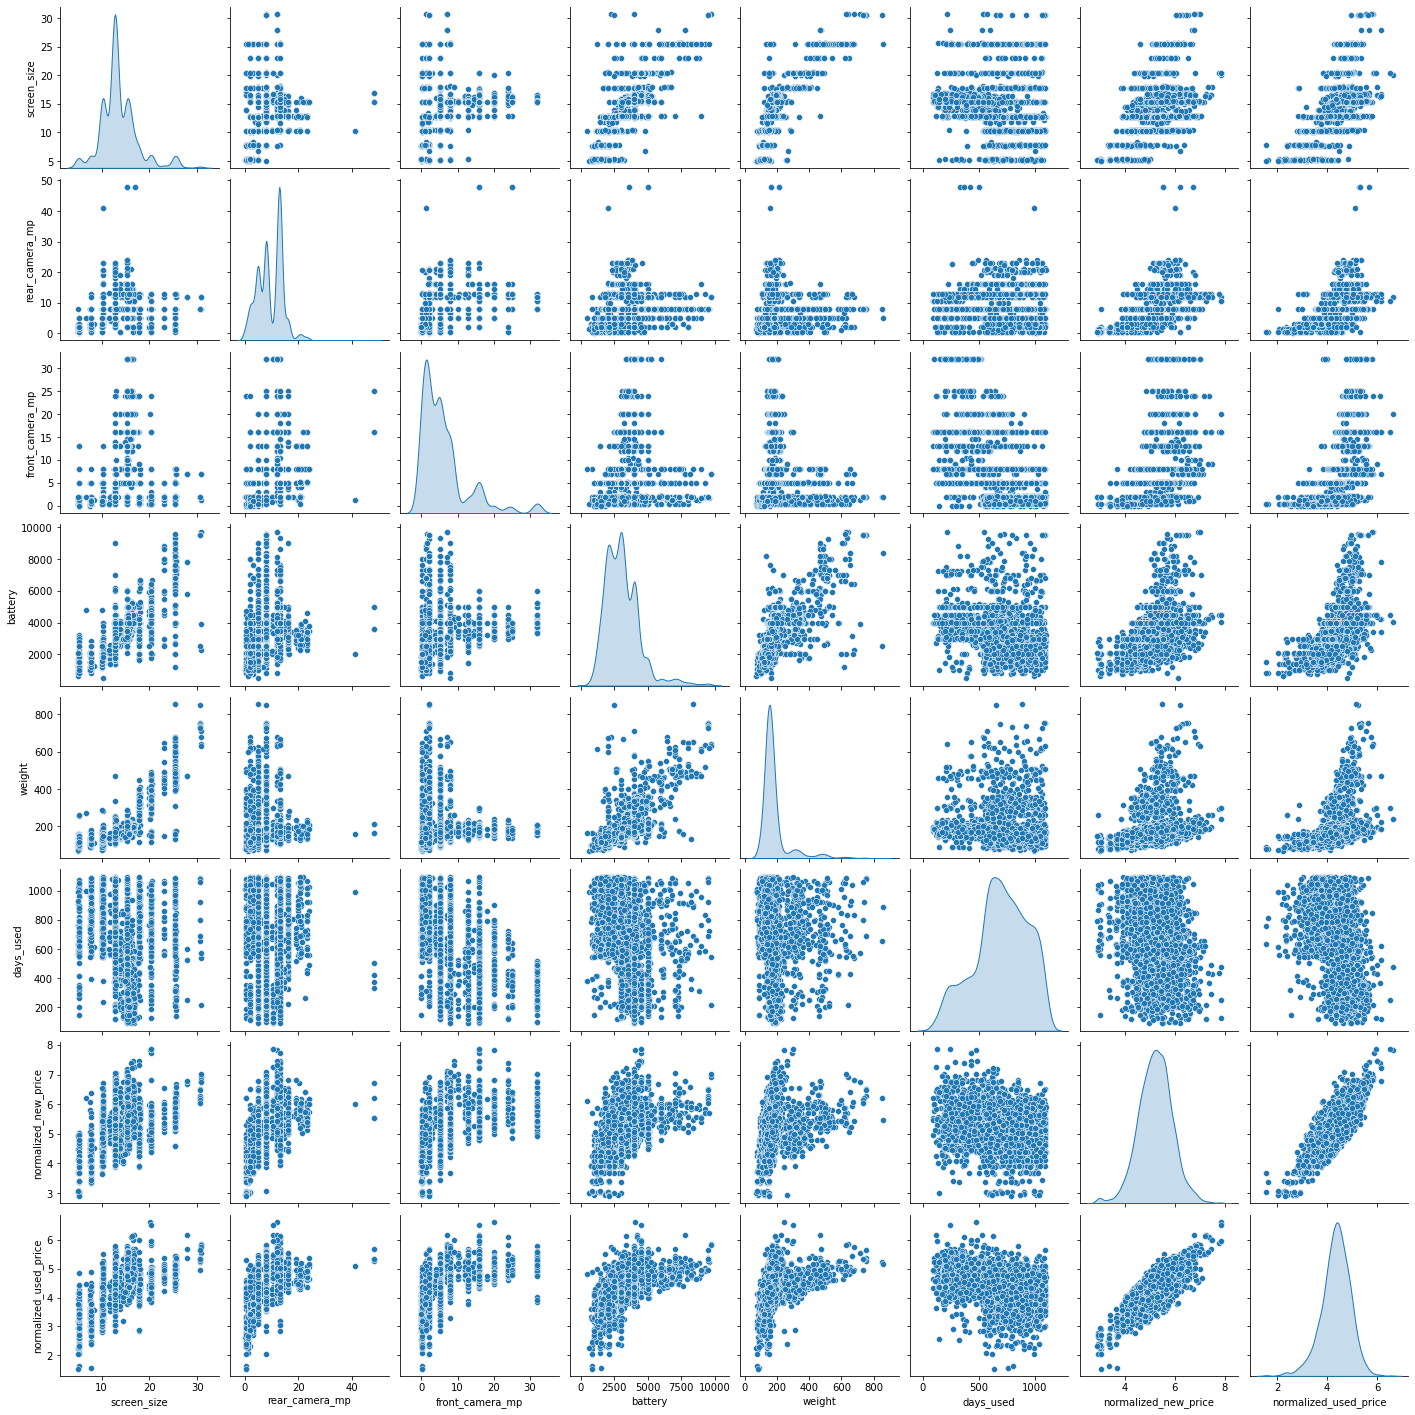

In [40]:
sns.pairplot(data[numerical_features],diag_kind='kde')
plt.show()

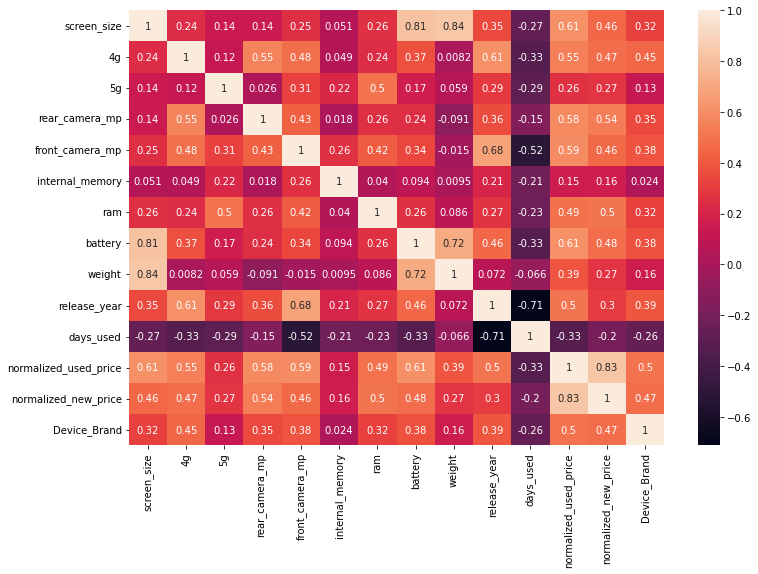

In [41]:
fig = plt.figure(figsize=(12,8))
sns.heatmap(data.corr(),annot=True)
plt.show()

# Relation between Features  
- __Used Price__ has the highest <font color=green>__positive__</font> correlation with __New Price__, followed by __battery__, __front camera__, __screen size__, __rear camera__ and __4G__.
- __Used Price__ has the highest <font color=red>__negative__</font> correlation with __Weight__ followed by __Days Used__. 

### There is a <font color=green>__positive__</font> correlation between  
   -  __Battery__ and __Screen Size__ __(HIGH)__    
   -  __Release Year__ and __Front Camera__ __(MODERATE)__  
   -  __Front Camera__ and __4G__ __(MODERATE)__  
   -  __Front Camera__ and __Rear Camera__ __(MODERATE)__  
   -  __Release Year__ and __4G__ __(MODERATE)__  
   -  __Rear Camera__ and __4G__ __(LOW)__  
   -  __Rear Camera__ and __New Price__ __(LOW)__  
   -  __New Price__ and __Battery__ __(LOW)__
   -  __New Price__ and __Screen Size__ __(LOW)__  
   -  __New Price__ and __Front Camera__ __(LOW)__    

### There is a <font color=red>__negative__</font> correlation between  
   -  __Battery__ and __Weight__ __(HIGH)__  
   -  __Screen Size__ and __Weight__ __(HIGH)__    
   -  __Days Used__ and __Release Year__ __(MODERATE)__    
   -  __Days used__ and __Front Camera__ __(MODERATE)__   

## Checking Outliers

In [42]:
cols=['screen_size','rear_camera_mp','front_camera_mp','battery','weight','days_used','normalized_new_price','normalized_used_price']

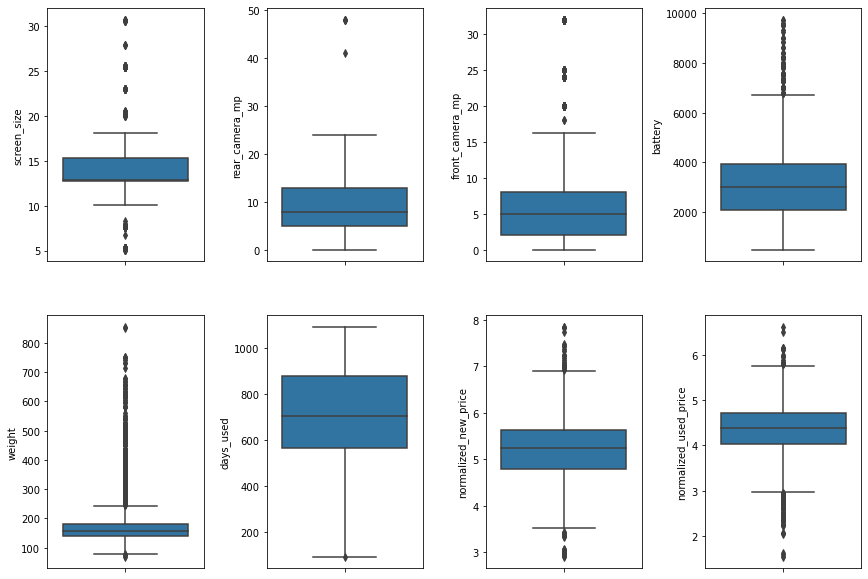

In [43]:
fig,ax=plt.subplots(2,4,figsize=(12,8))
index=0
ax=ax.flatten()
for col in cols:
    sns.boxplot(y=col,data=data,ax=ax[index])
    index+=1
plt.tight_layout(pad=0.5, w_pad=1, h_pad=5.0)

# Function to detect outliers

In [44]:
def detect_outliers(column):
    outlier_indices=[]
    
    for col in column:
        #1st quartile
        Q1=np.percentile(data[col],25)
        
        #3rd quartile
        Q3=np.percentile(data[col],75)
        #IQR
        IQR=Q3-Q1
        outlier_step=IQR*1.5
        
        #detect outlier and indices
        
        outlier_list_col=data[(data[col] < Q1 - outlier_step)
                              | (data[col] > Q3 + outlier_step)].index
        
        # store indeces
        outlier_indices.extend(outlier_list_col)
        return outlier_indices
    
len(detect_outliers(cols))


440

__440__ outliers found _!_

# Checking skewness of data

In [45]:
def check_skweness(columnName):
    print('''Before Correcting''')
    try:
        (mu, sigma) = norm.fit(data[columnName])
    except RuntimeError:
        (mu,sigma) = norm.fit(data[columnName].dropna())
    print("Mu before correcting {} : {}, Sigma before correcting {} : {}".format(
        columnName.upper(), mu, columnName.upper(), sigma))
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    sns.distplot(data[columnName], fit=norm, color="orange")
    plt.title(columnName.upper() +
              " Distplot before Skewness Correction", color="black")
    plt.subplot(1,2,2)
    stats.probplot(data[columnName], plot=plt)
    plt.show();

Before Correcting
Mu before correcting SCREEN_SIZE : 13.617476175837686, Sigma before correcting SCREEN_SIZE : 3.850927722248345


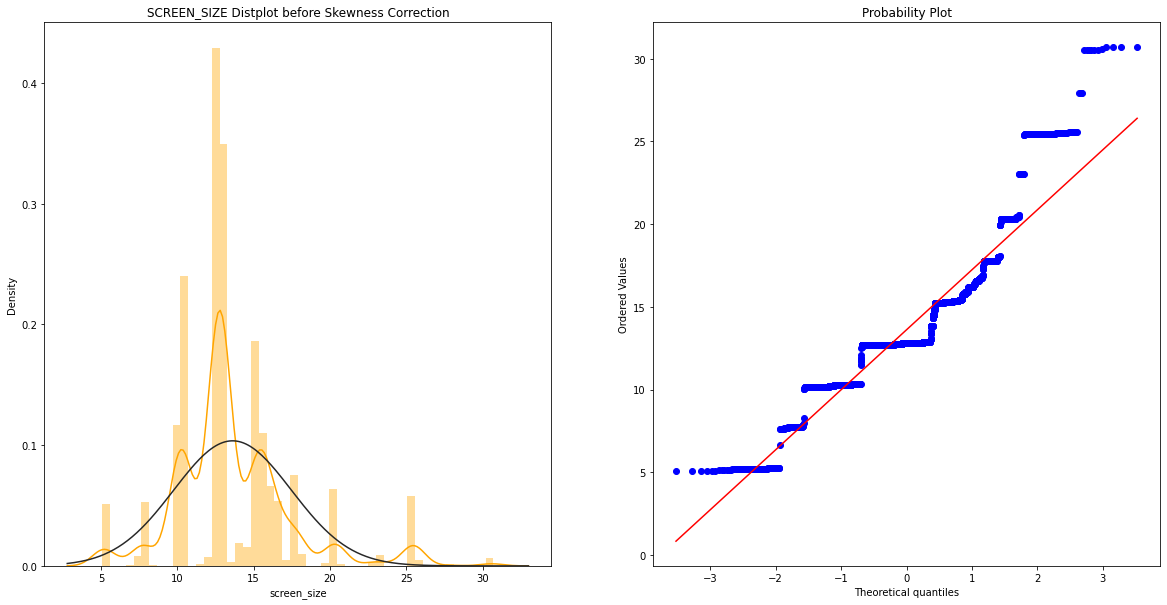

Before Correcting
Mu before correcting REAR_CAMERA_MP : 9.476354134644943, Sigma before correcting REAR_CAMERA_MP : 4.801461330992338


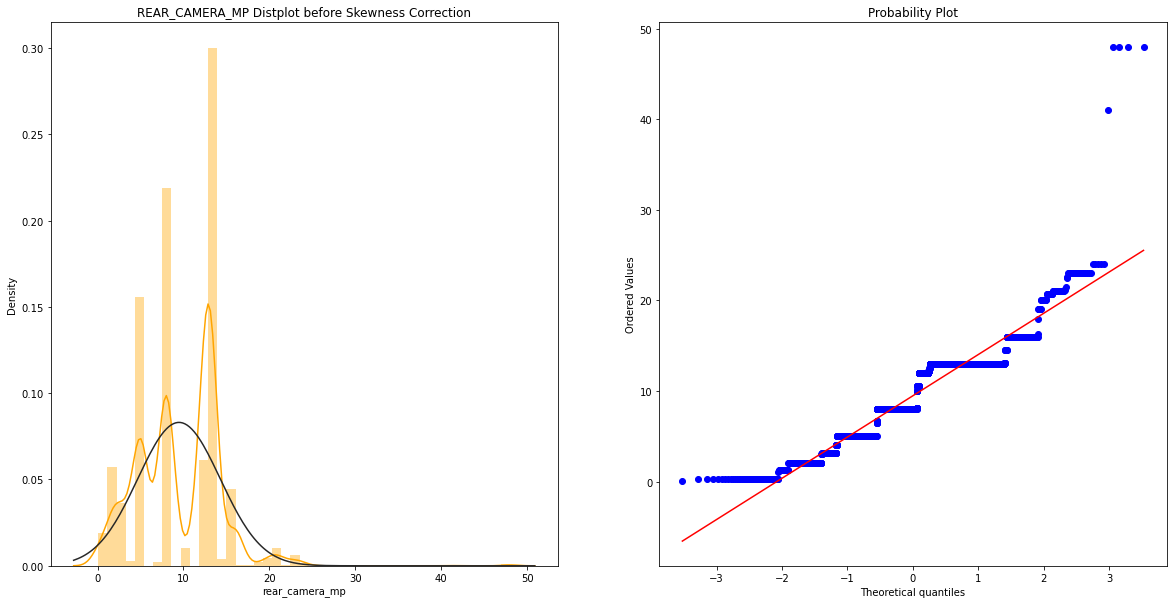

Before Correcting
Mu before correcting FRONT_CAMERA_MP : 6.093790347371658, Sigma before correcting FRONT_CAMERA_MP : 6.59856537717815


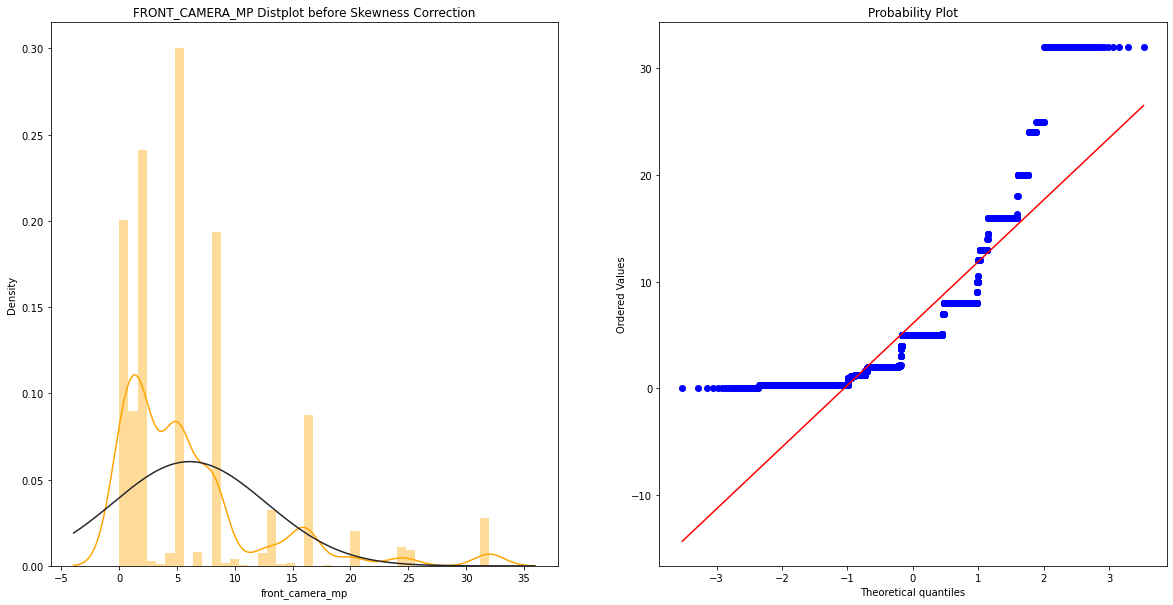

Before Correcting
Mu before correcting BATTERY : 3074.926990470335, Sigma before correcting BATTERY : 1296.758255626418


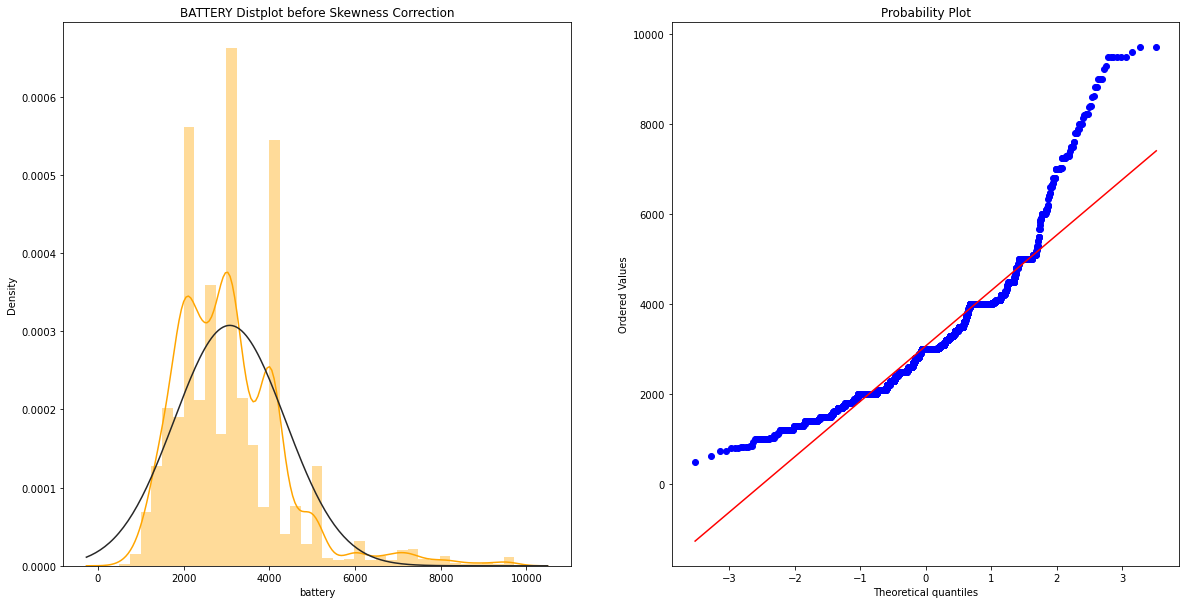

Before Correcting
Mu before correcting WEIGHT : 182.49363664309868, Sigma before correcting WEIGHT : 90.34592055359136


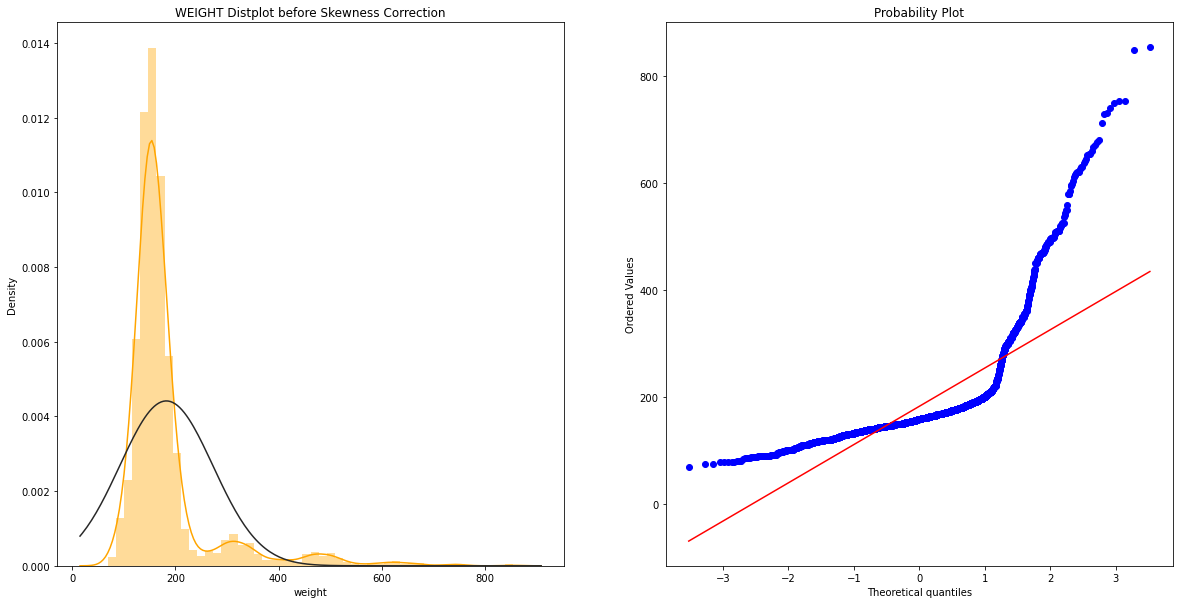

Before Correcting
Mu before correcting DAYS_USED : 695.695358130956, Sigma before correcting DAYS_USED : 235.4178911895456


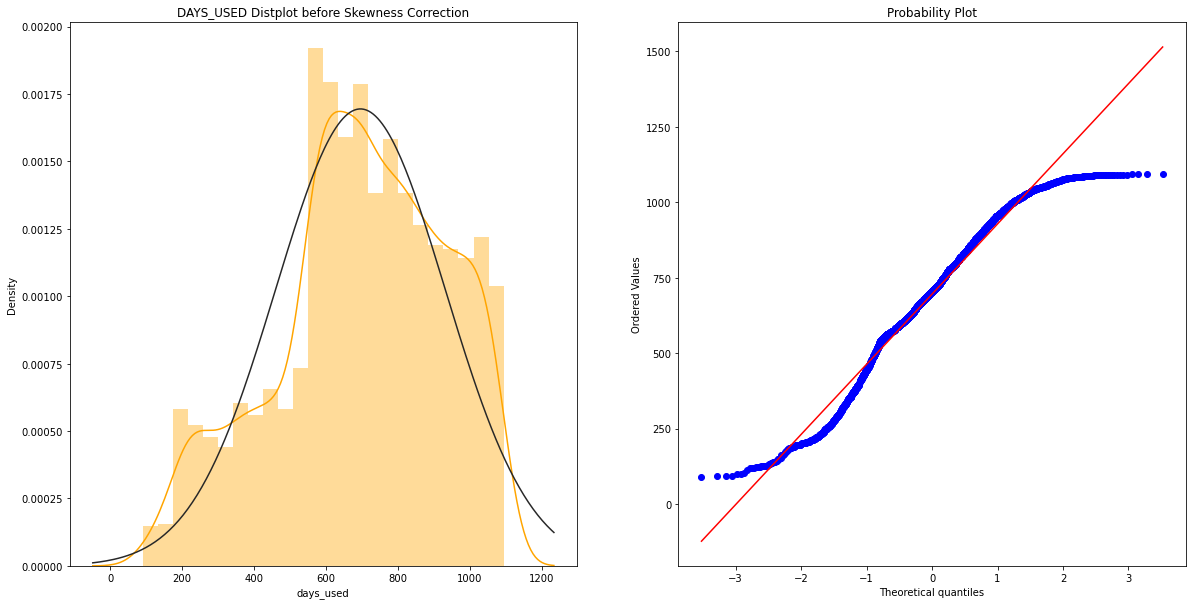

In [46]:
skew_check_cols = ['screen_size','rear_camera_mp','front_camera_mp','battery','weight','days_used']
for columns in skew_check_cols:
    check_skweness(columns)

# Function to apply different tranformations on variables to get normalized data

In [47]:
def trying_different_transformations(column,transformation):
    if transformation=='boxcox':
        try:
            print("BoxCox - "+column)
            temp,temp_params = boxcox(data[column]+1)
            (mu,sigma)=norm.fit(temp)
            print("mu ",mu," sigma ",sigma)
            plt.figure(figsize=(20,10))
            plt.subplot(1,2,1)
            sns.distplot(temp, fit=norm, color="orange")
            plt.subplot(1,2,2)
            stats.probplot(temp, plot = plt)
        except ValueError:
            pass
        except ValueError:
            pass
    elif transformation=='log':
        try:
            print("Log - "+column)
            (mu,sigma)=norm.fit(np.log1p(data[column]))
            print("mu ",mu," sigma ",sigma)
            plt.figure(figsize=(20,10))
            plt.subplot(1,2,1)
            sns.distplot(np.log1p(data[column]), fit=norm, color="orange")
            plt.subplot(1,2,2)
            stats.probplot(np.log1p(data[column]), plot = plt)
        except RuntimeError:
            pass
        except ValueError:
            pass
    elif transformation=='reciprocal':
        try:
            print("Reciprocal - "+column)
            temp_r = 1/data[column]
            temp_r = temp_r.replace([np.inf, -np.inf], 0)
            (mu,sigma)=norm.fit(temp_r)
            print("mu ",mu," sigma ",sigma)
            plt.figure(figsize=(20,10))
            plt.subplot(1,2,1)
            sns.distplot(temp_r, fit=norm, color="orange")
            plt.subplot(1,2,2)
            stats.probplot(temp_r, plot = plt)
        except RuntimeError:
            pass
        except ValueError:
            pass
    elif transformation=='sqroot':
        try:
            print("Square_Root - "+column)
            (mu,sigma)=norm.fit(data[column]**(1/2))
            print("mu ",mu," sigma ",sigma)
            plt.figure(figsize=(20,10))
            plt.subplot(1,2,1)
            sns.distplot(data[column]**(1/2), fit=norm, color="orange")
            plt.subplot(1,2,2)
            stats.probplot(data[column]**(1/2), plot = plt)
        except RuntimeError:
            pass
        except ValueError:
            pass
    else:
        try:
            print("Exponential - "+column)
            (mu,sigma)=norm.fit(data[column]**(1/1.2))
            print("mu ",mu," sigma ",sigma)
            plt.figure(figsize=(20,10))
            plt.subplot(1,2,1)
            sns.distplot(data[column]**(1/1.2), fit=norm, color="orange")
            plt.subplot(1,2,2)
            stats.probplot(data[column]**(1/1.2), plot = plt)
        except RuntimeError:
            pass
        except ValueError:
            pass

# Transformations to try !
- __Boxcox__
- __Log__
- __Reciprocal__
- __Squareroot__
- __Exponential__

# Trying different transformations on screen_size feature

BoxCox - screen_size
mu  3.5698404424676915  sigma  0.4545136324169383
Log - screen_size
mu  2.6489500119971527  sigma  0.2597925882344679
Reciprocal - screen_size
mu  0.07960684557547834  sigma  0.025525098428114866
Square_Root - screen_size
mu  3.6549818070083795  sigma  0.5085117169500123
Exponential - screen_size
mu  8.765467966999235  sigma  2.0485469876423363


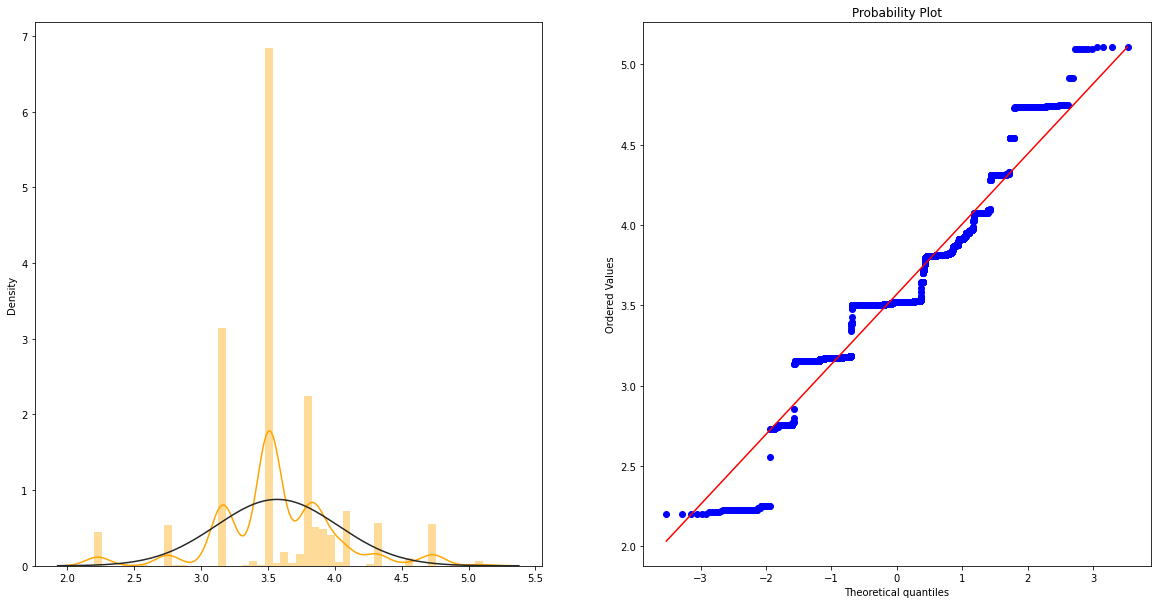

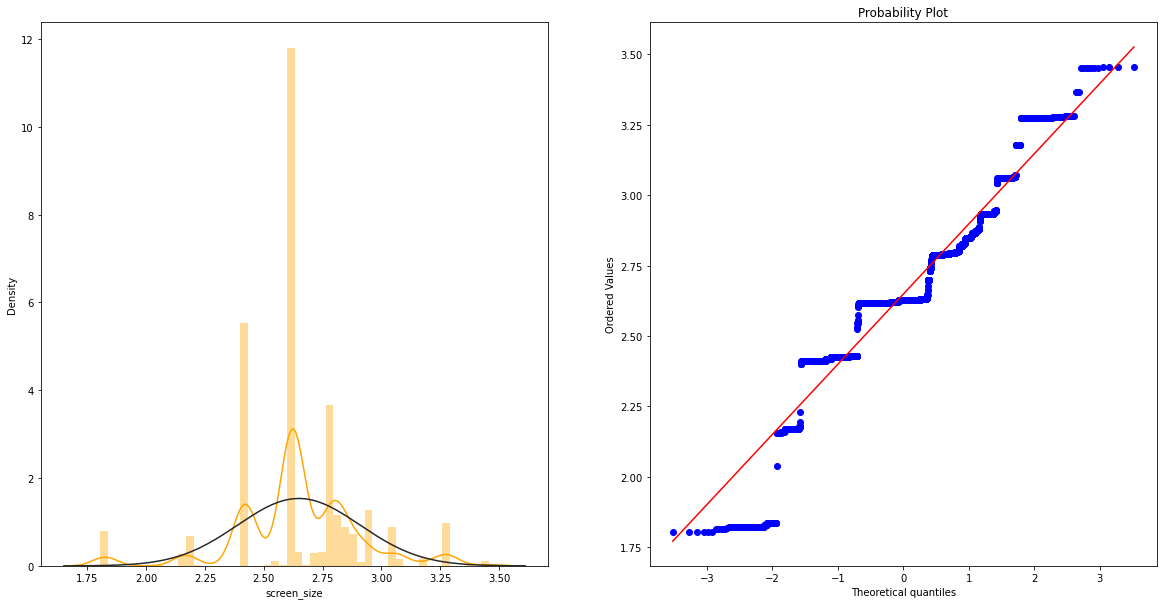

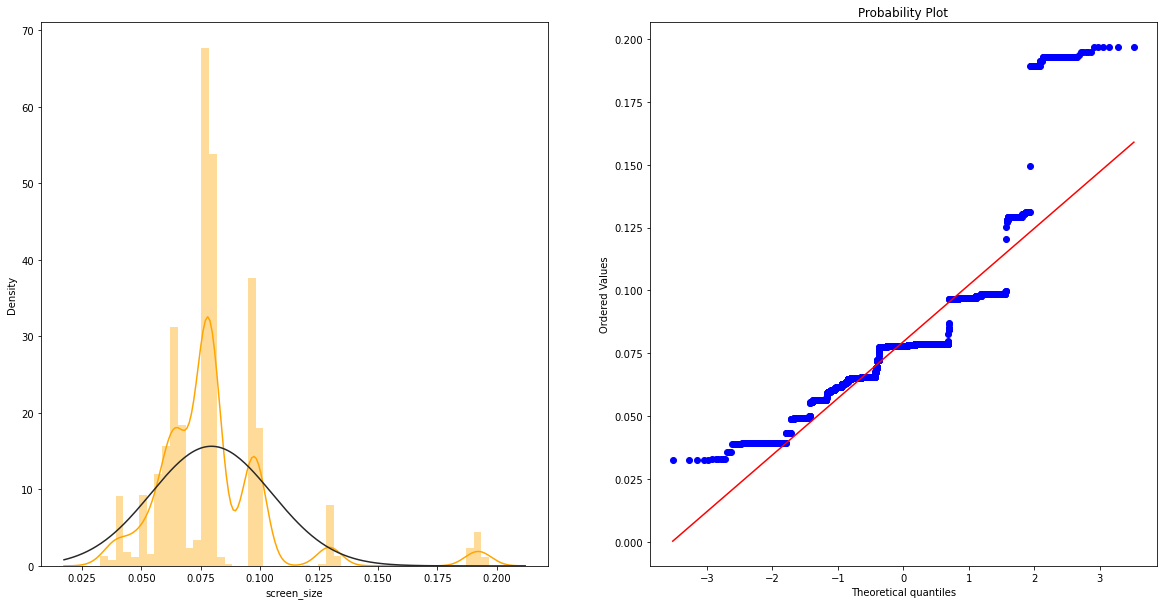

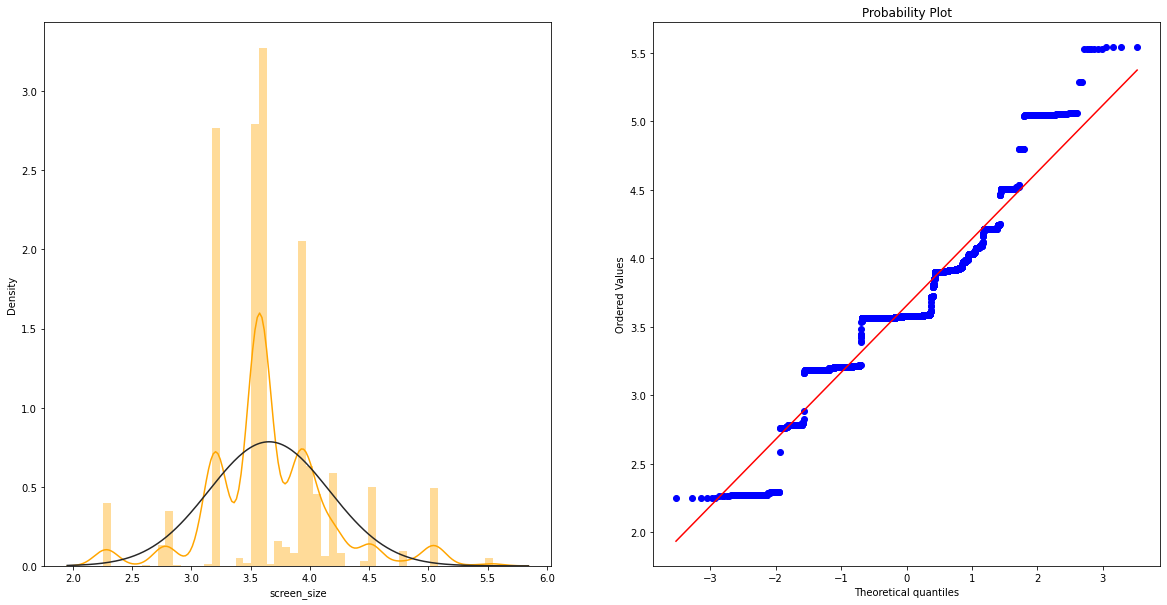

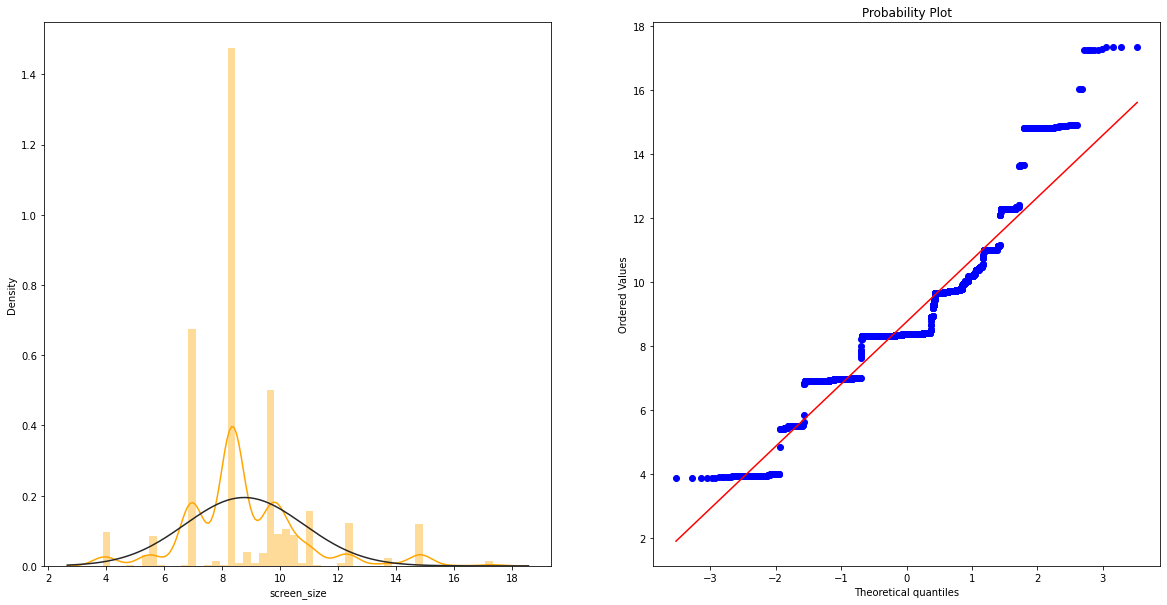

In [48]:
transformations = ['boxcox','log','reciprocal','sqroot','exp']
for x in transformations:
    trying_different_transformations('screen_size',x)

# Trying different transformations on rear_camera_mp feature

BoxCox - rear_camera_mp
mu  5.561195580291284  sigma  2.275511236944538
Log - rear_camera_mp
mu  2.2166565580441495  sigma  0.5686388346206583
Reciprocal - rear_camera_mp
mu  0.21288679387362286  sigma  0.5034662710014629
Square_Root - rear_camera_mp
mu  2.9592967600910938  sigma  0.847889627462975
Exponential - rear_camera_mp
mu  6.386109911940589  sigma  2.776726315977432


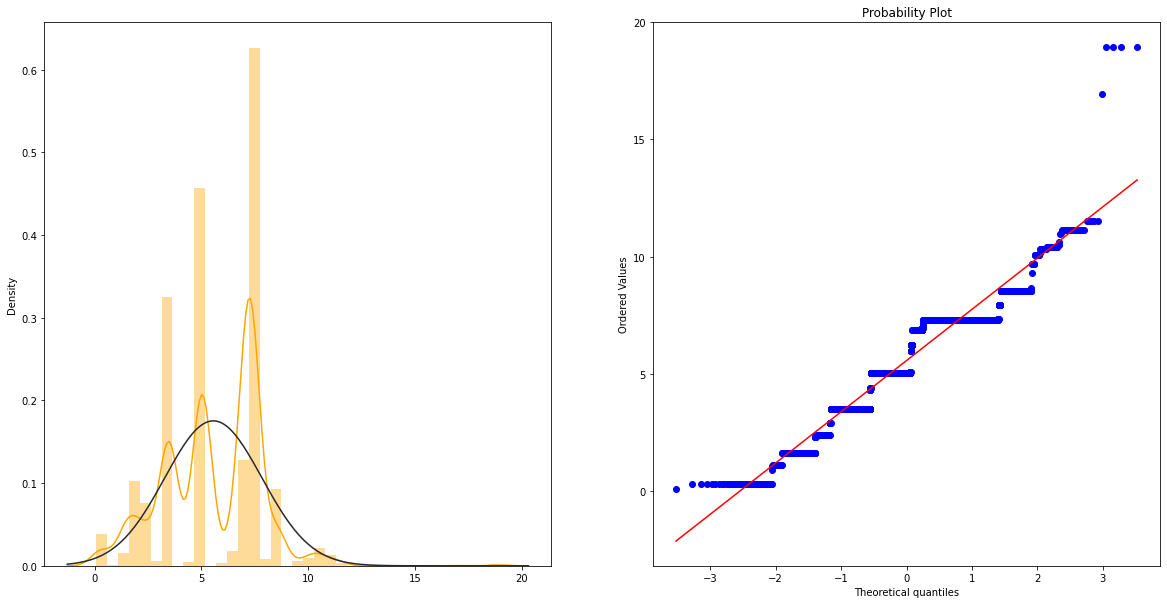

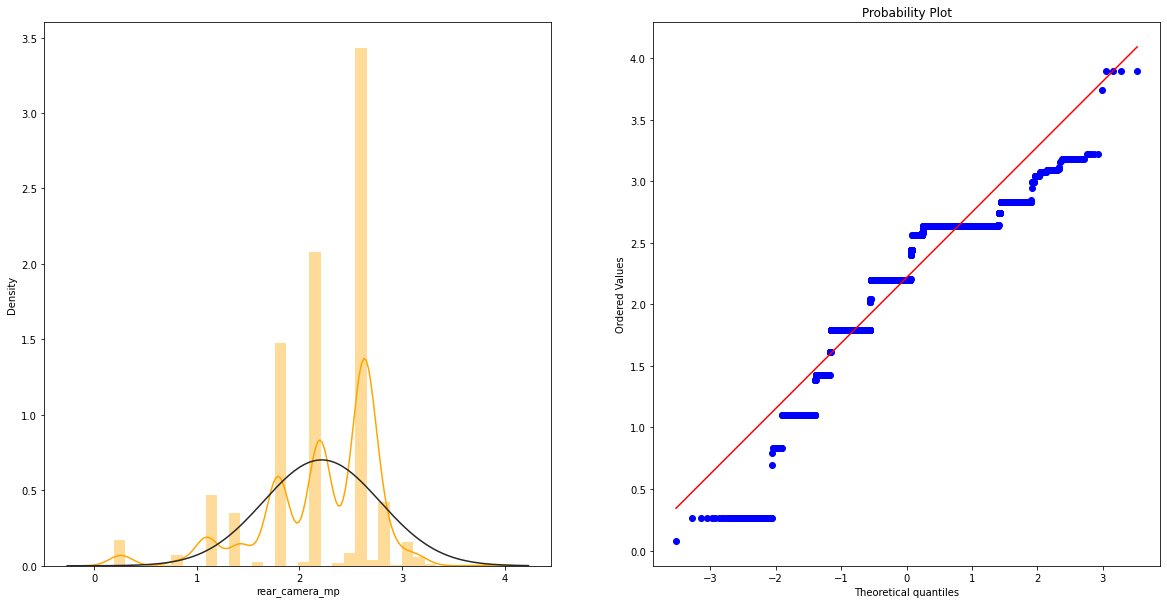

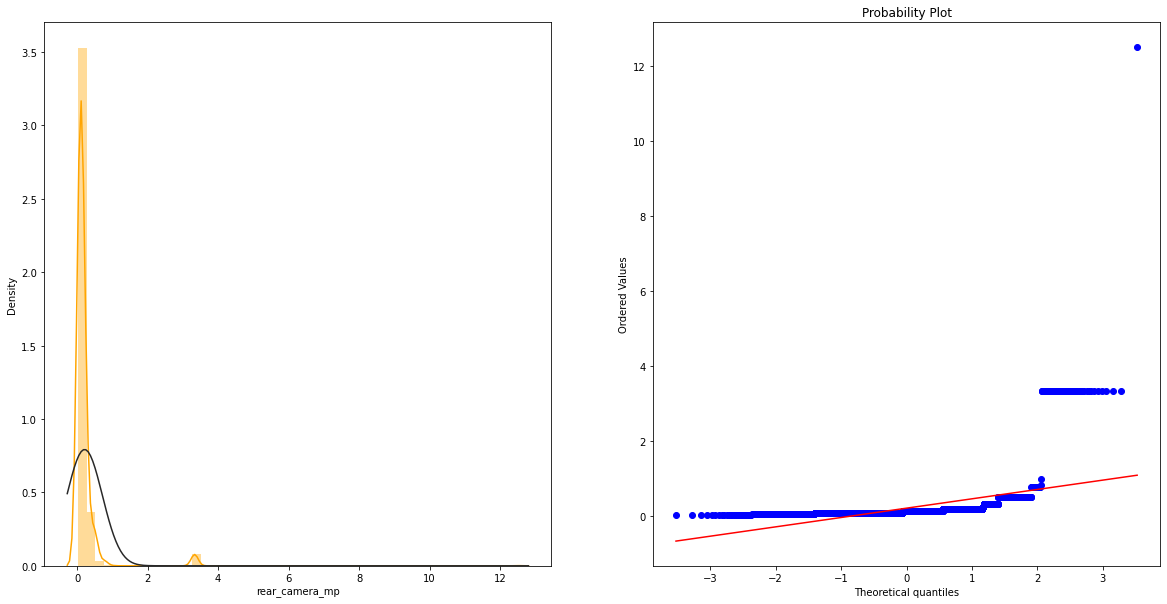

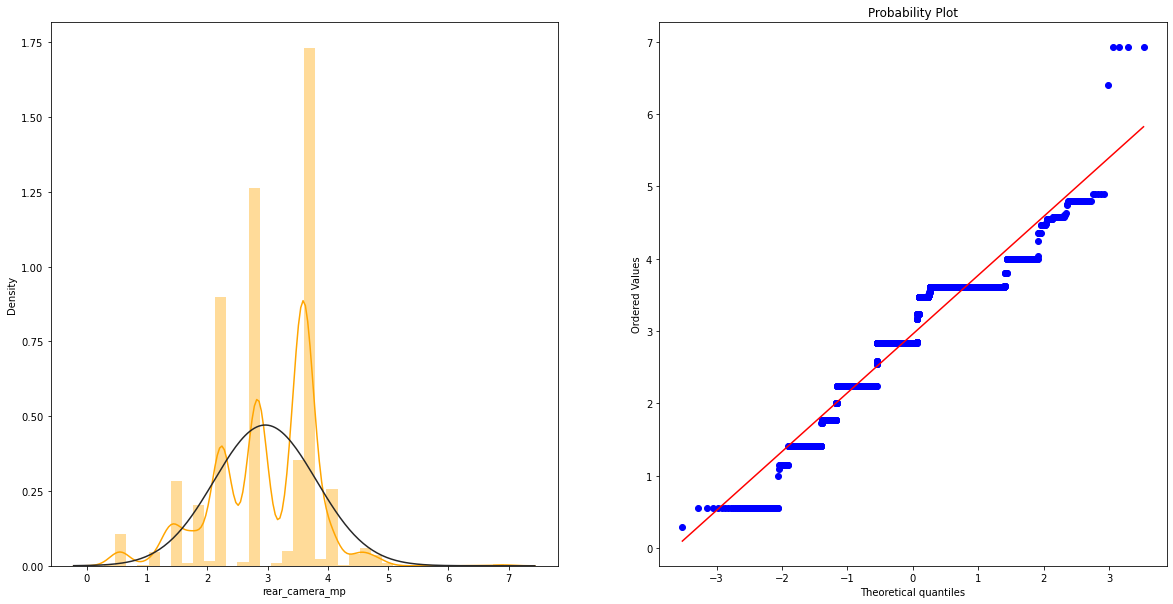

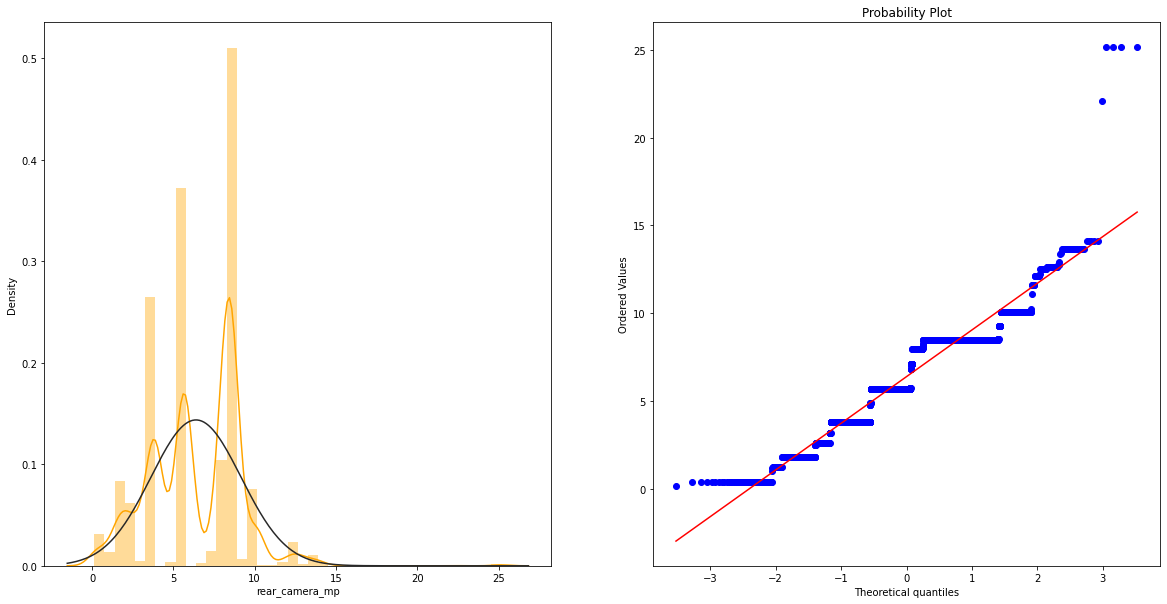

In [49]:
for x in transformations:
    trying_different_transformations('rear_camera_mp',x)

# Trying different transformations on front_camera_mp feature

BoxCox - front_camera_mp
mu  1.5268144858285813  sigma  0.8193688139683319
Log - front_camera_mp
mu  1.5881763402721587  sigma  0.8715756237382545
Reciprocal - front_camera_mp
mu  0.7395276436723018  sigma  1.1133356363904017
Square_Root - front_camera_mp
mu  2.1439325683717114  sigma  1.2236598749843581
Exponential - front_camera_mp
mu  4.201861528431512  sigma  3.818759083260187


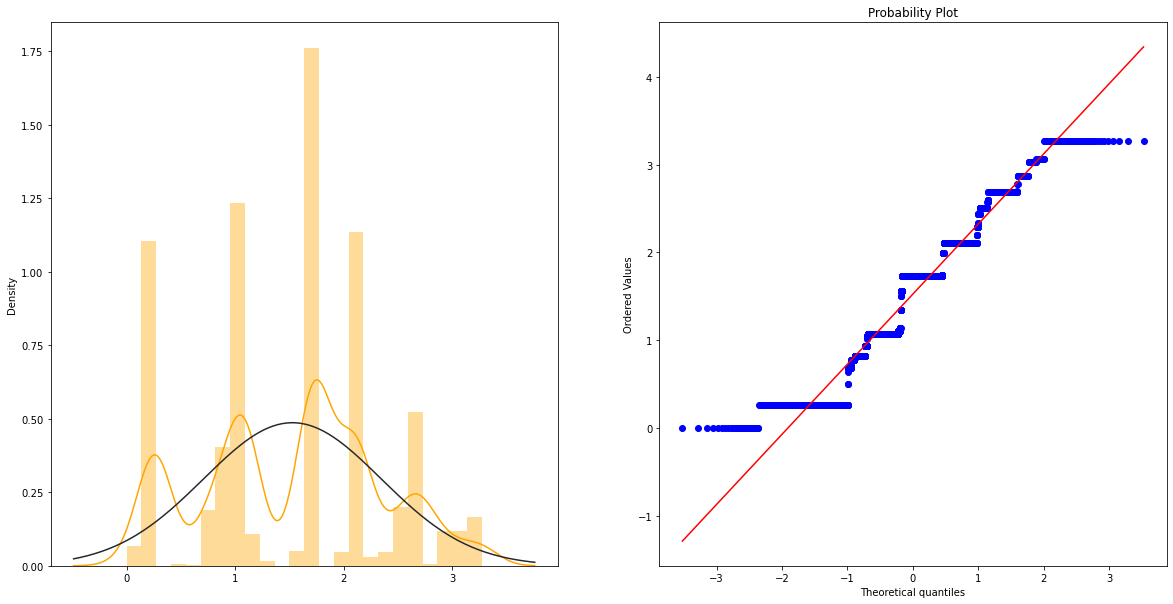

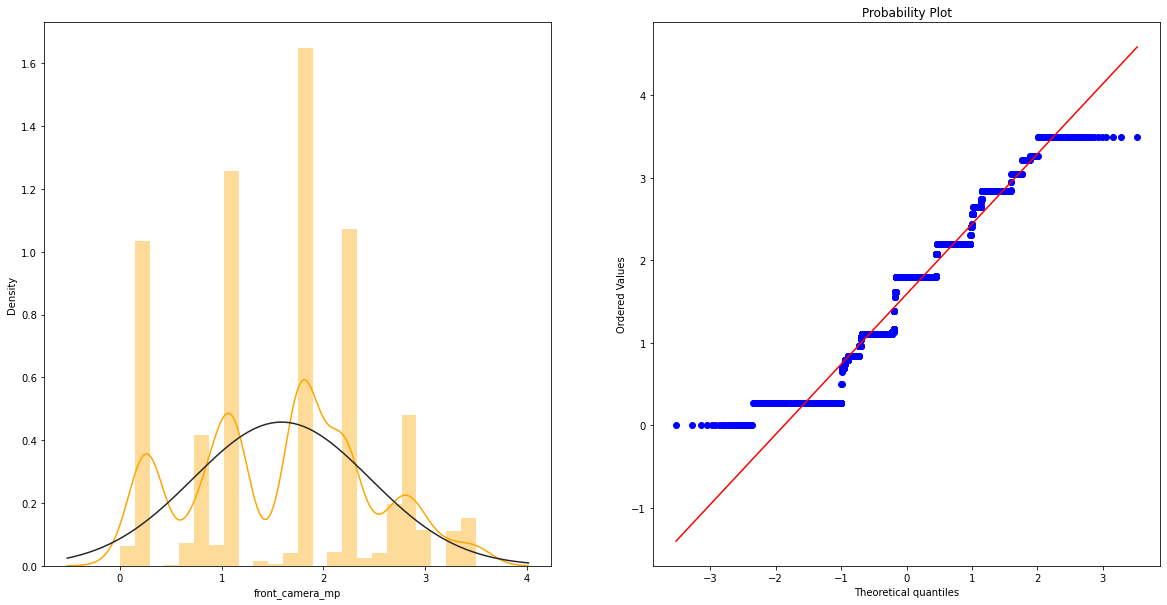

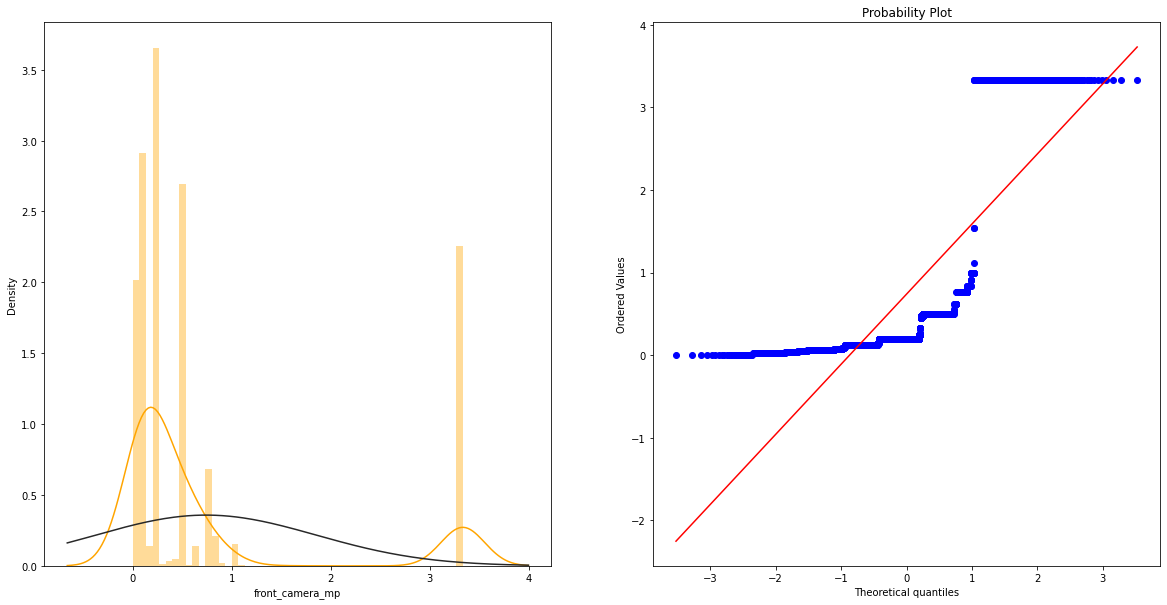

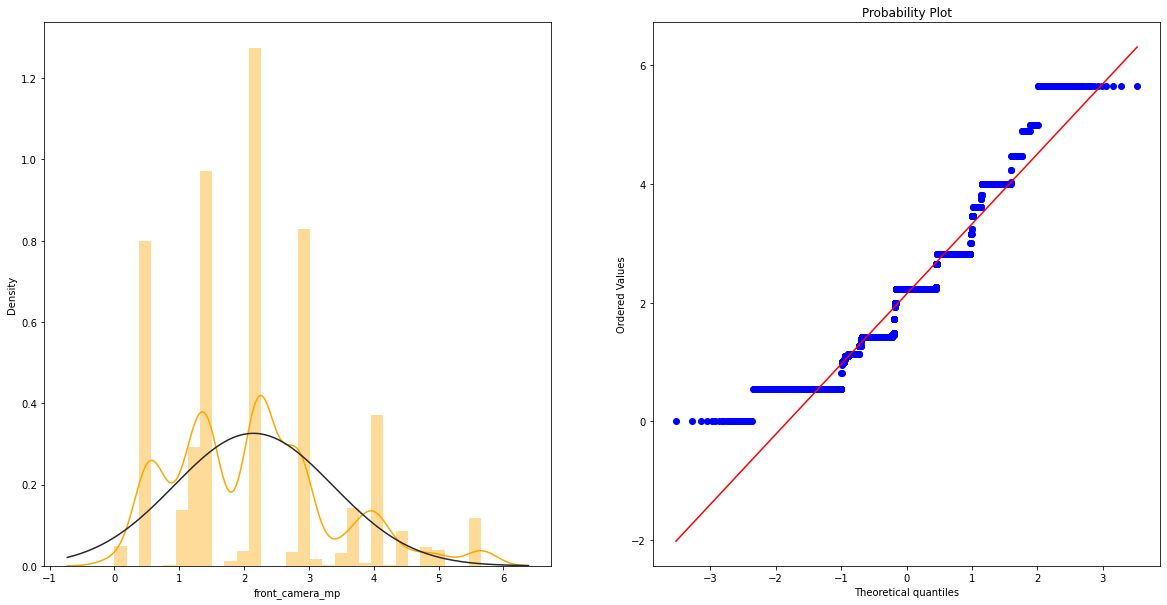

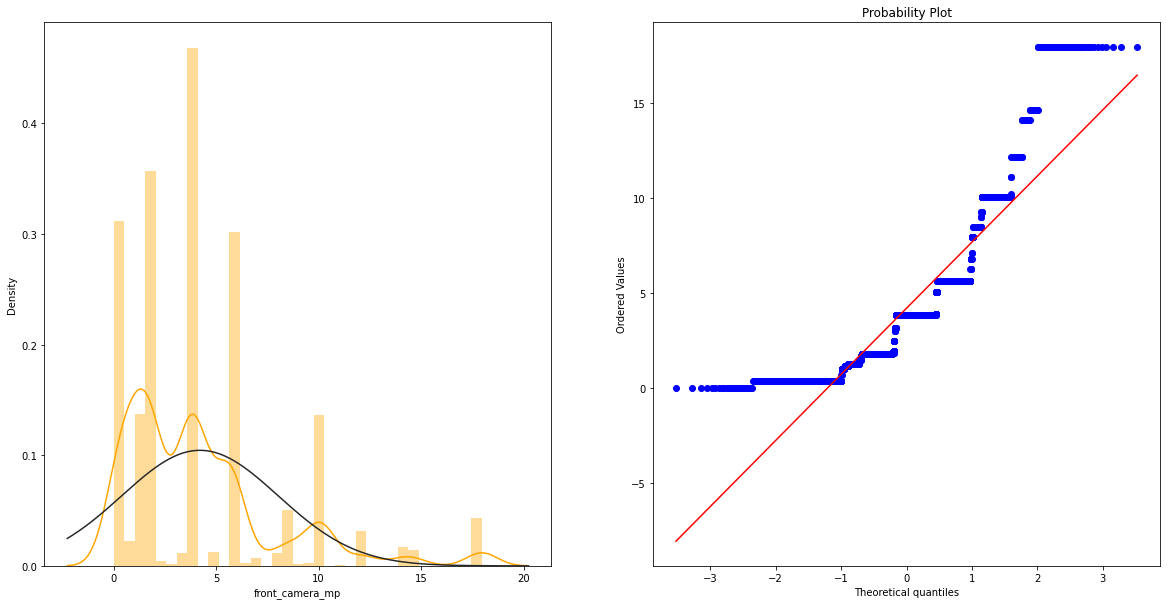

In [50]:
for x in transformations:
    trying_different_transformations('front_camera_mp',x)

# Trying different transformations on battery feature

BoxCox - battery
mu  9.140952023574444  sigma  0.5274073169353909
Log - battery
mu  7.950738907016909  sigma  0.4018552646649475
Reciprocal - battery
mu  0.00038254872318301626  sigma  0.00016467025906119576
Square_Root - battery
mu  54.34431173601634  sigma  11.028271505952869
Exponential - battery
mu  797.3570202661799  sigma  275.7825894042893


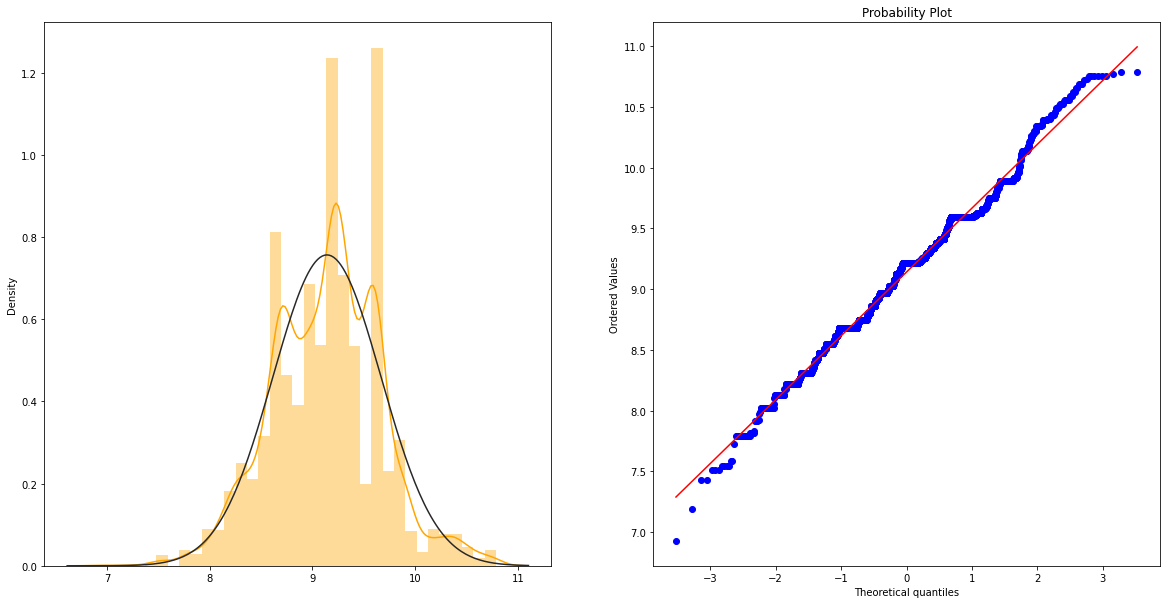

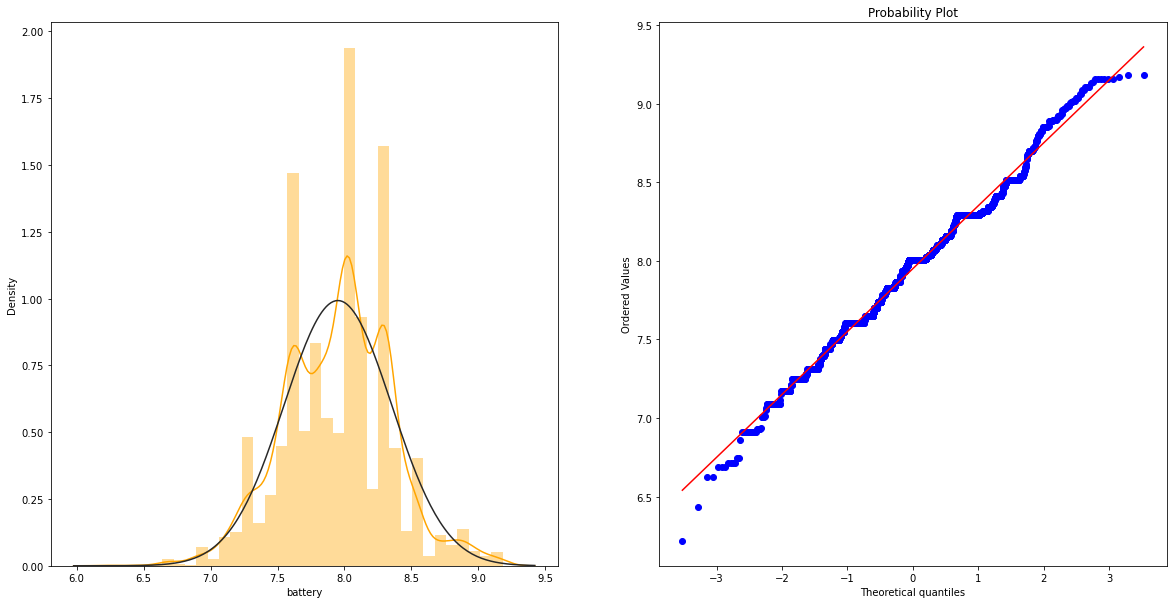

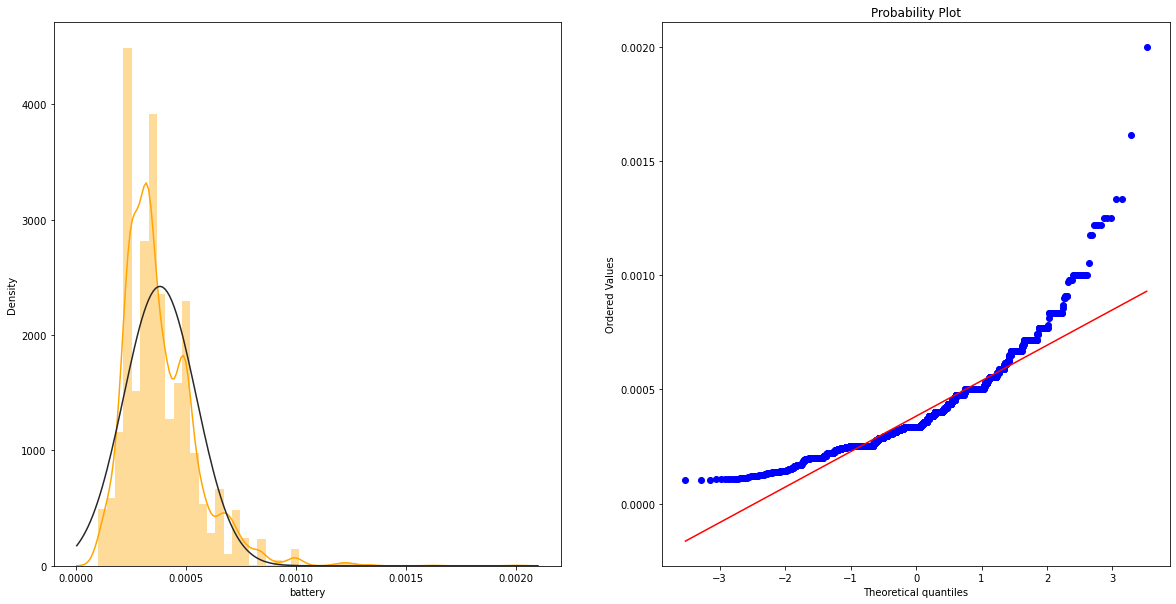

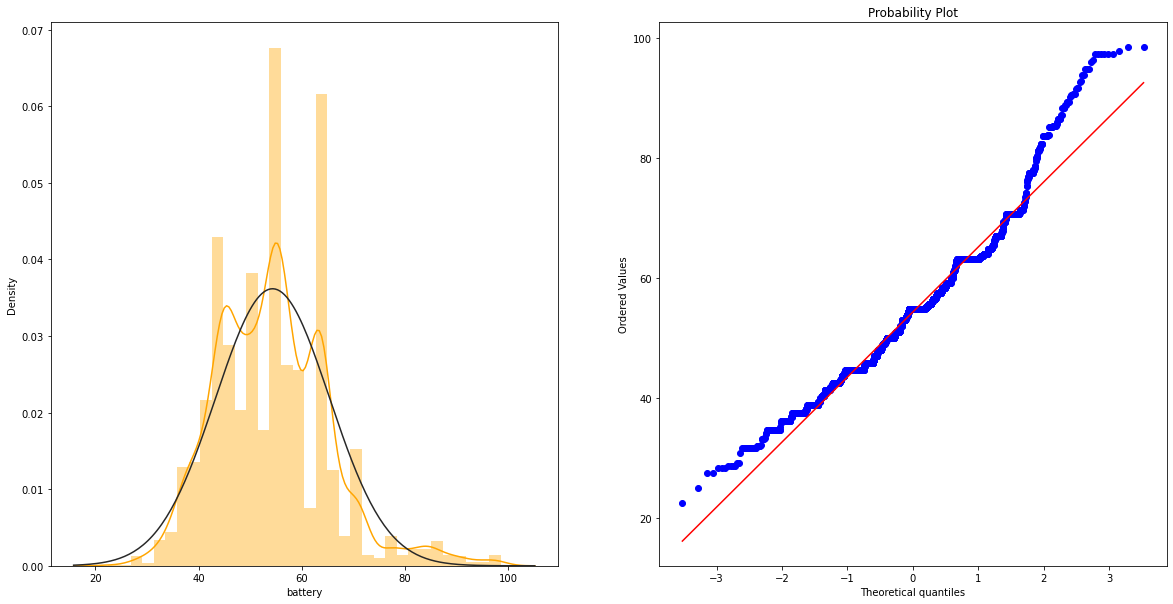

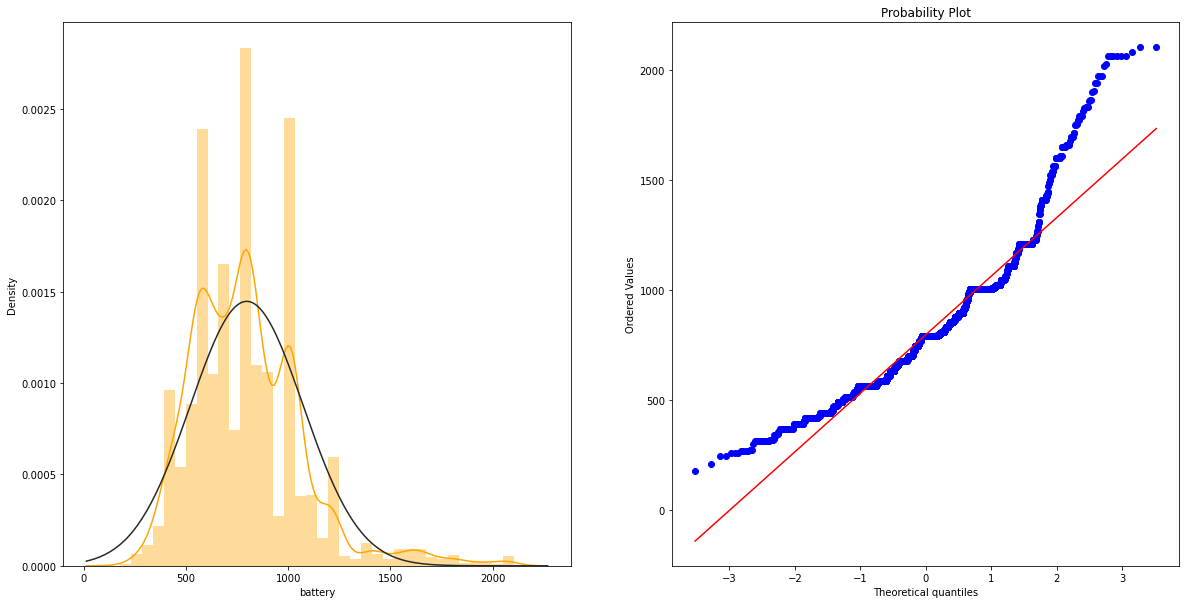

In [51]:
for x in transformations:
    trying_different_transformations('battery',x)

# Trying different transformations on weight feature

BoxCox - weight
mu  0.8331451980180247  sigma  0.0006235641366920061
Log - weight
mu  5.1382326242001595  sigma  0.3466813526975624
Reciprocal - weight
mu  0.006213180426972396  sigma  0.0017488702471315902
Square_Root - weight
mu  13.23412673316506  sigma  2.711369811299194
Exponential - weight
mu  75.69601373789506  sigma  29.257851090331783


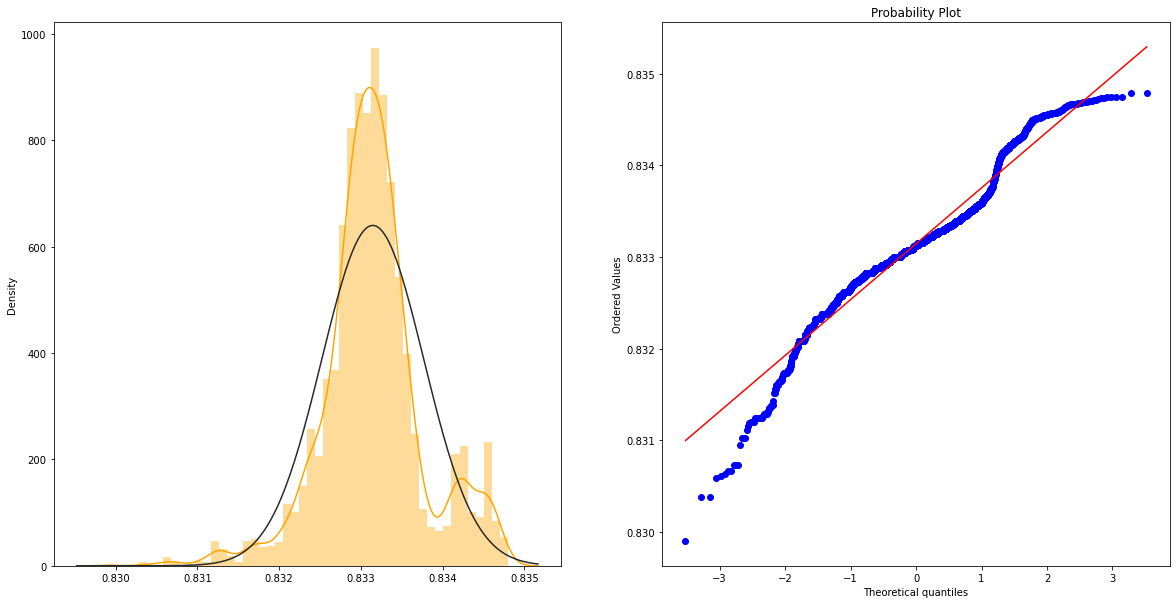

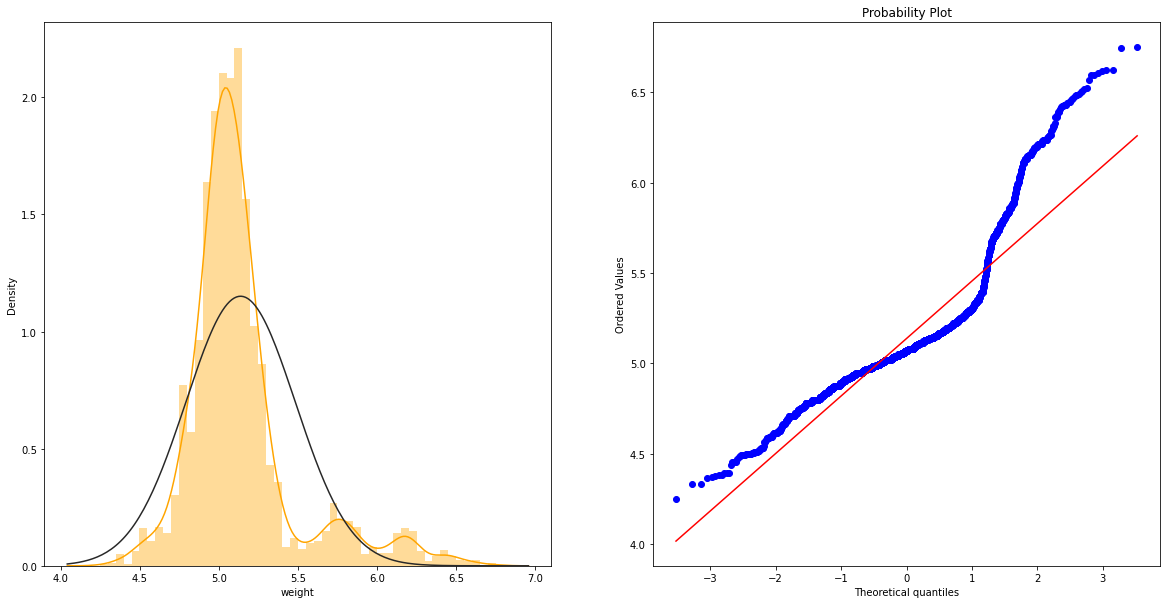

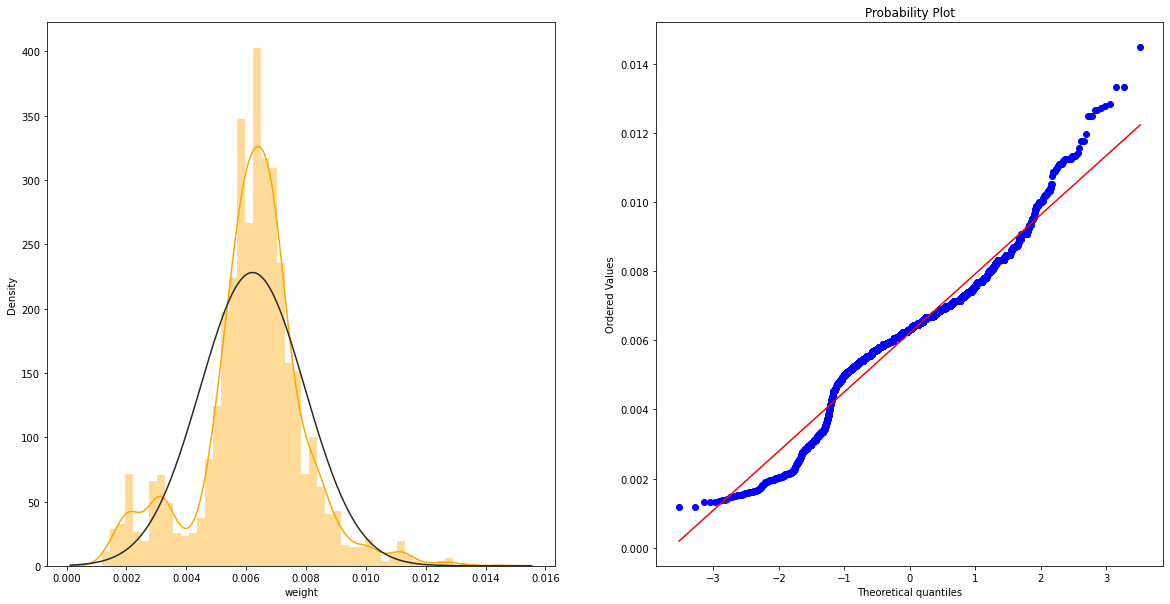

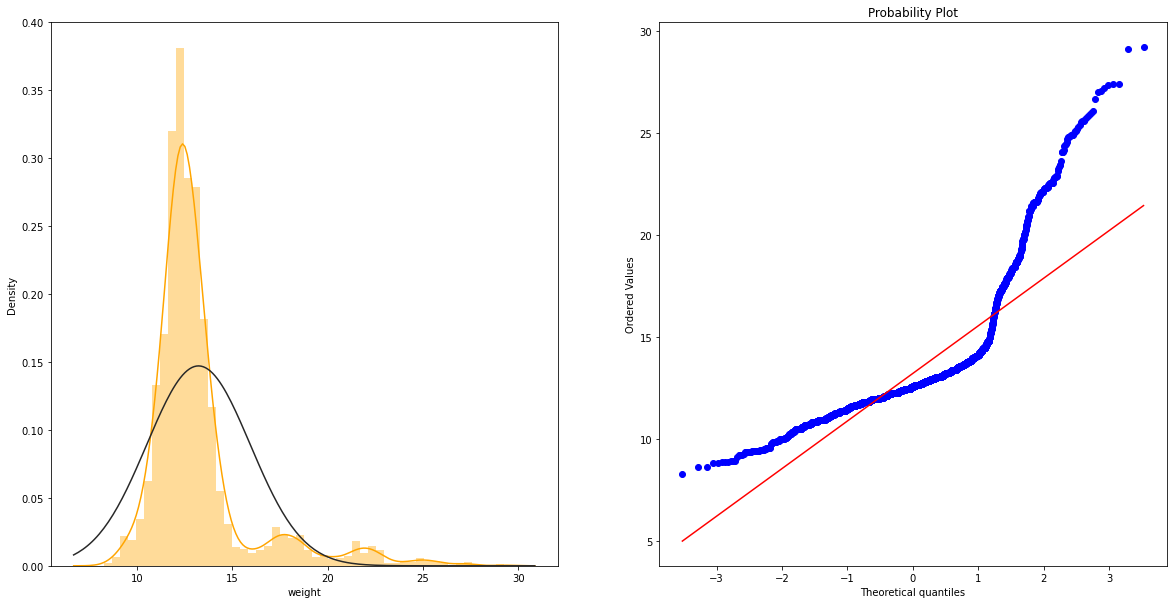

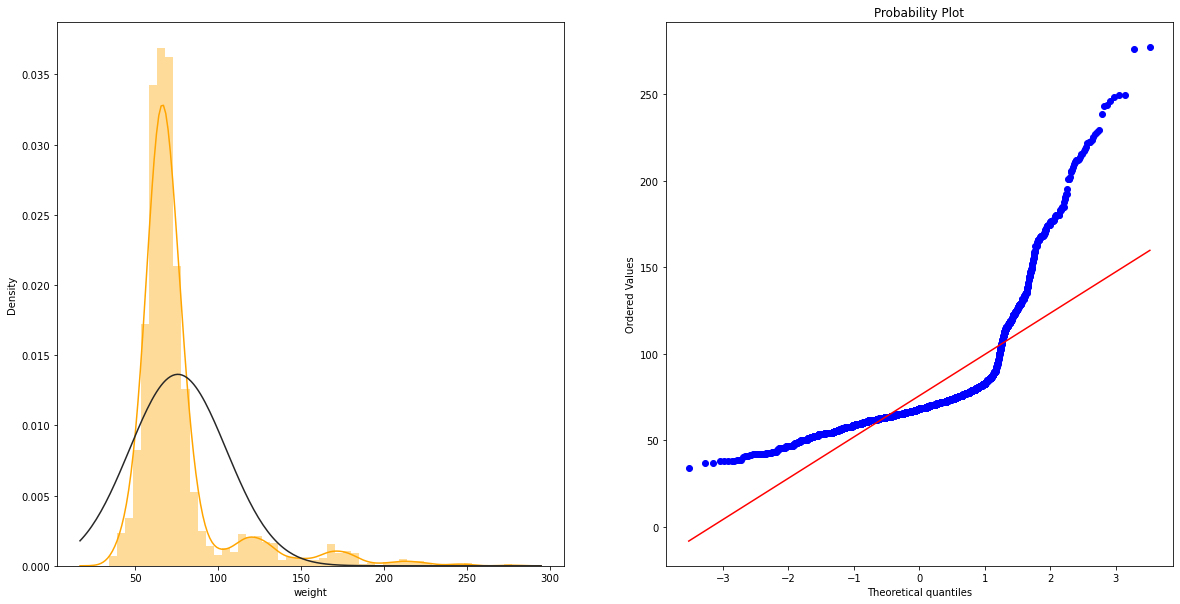

In [52]:
for x in transformations:
    trying_different_transformations('weight',x)

# Trying different transformations on days_used feature

BoxCox - days_used
mu  3496.8057898989555  sigma  1439.0442684769423
Log - days_used
mu  6.468905953652584  sigma  0.4336628749605923
Reciprocal - days_used
mu  0.0017471434574026178  sigma  0.0011108860529121054
Square_Root - days_used
mu  25.917714586315785  sigma  4.895654067969873
Exponential - days_used
mu  231.58748020692875  sigma  67.54464188114896


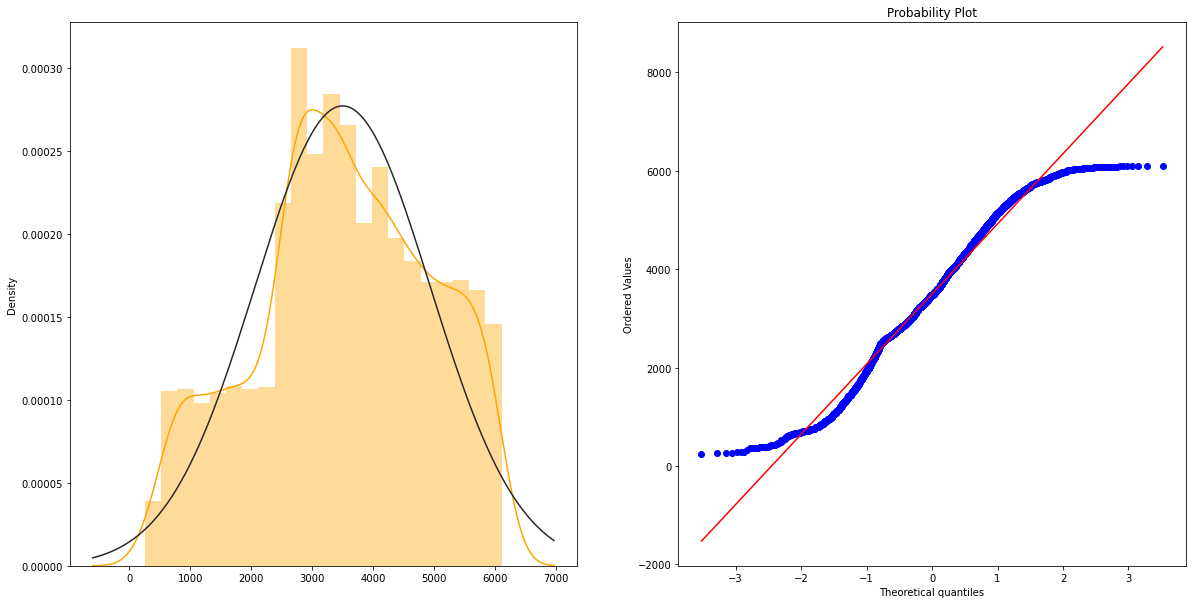

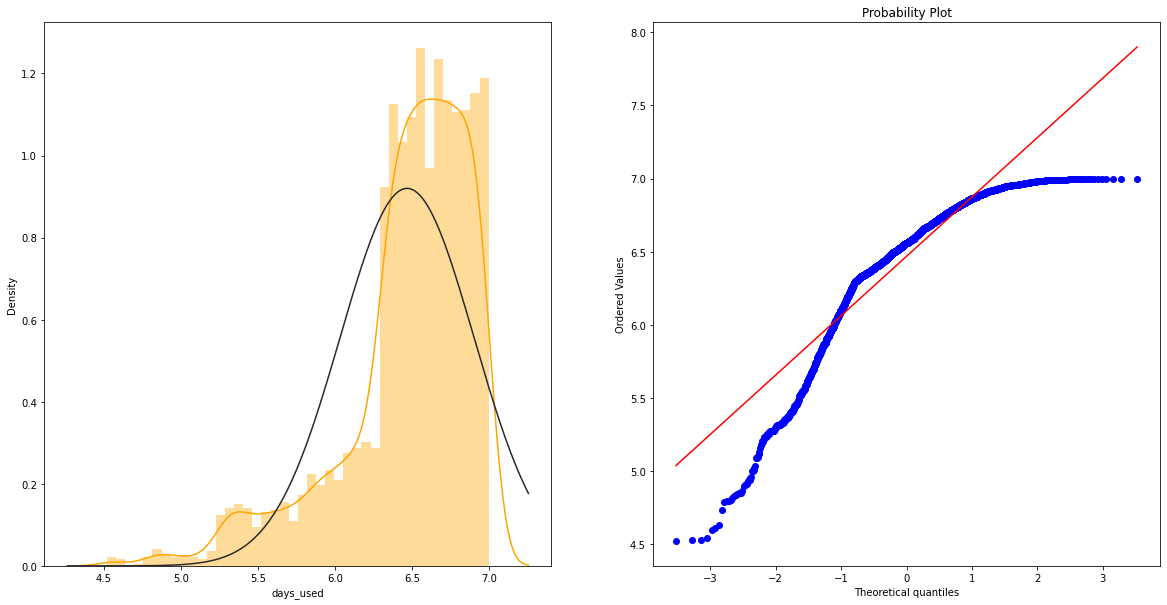

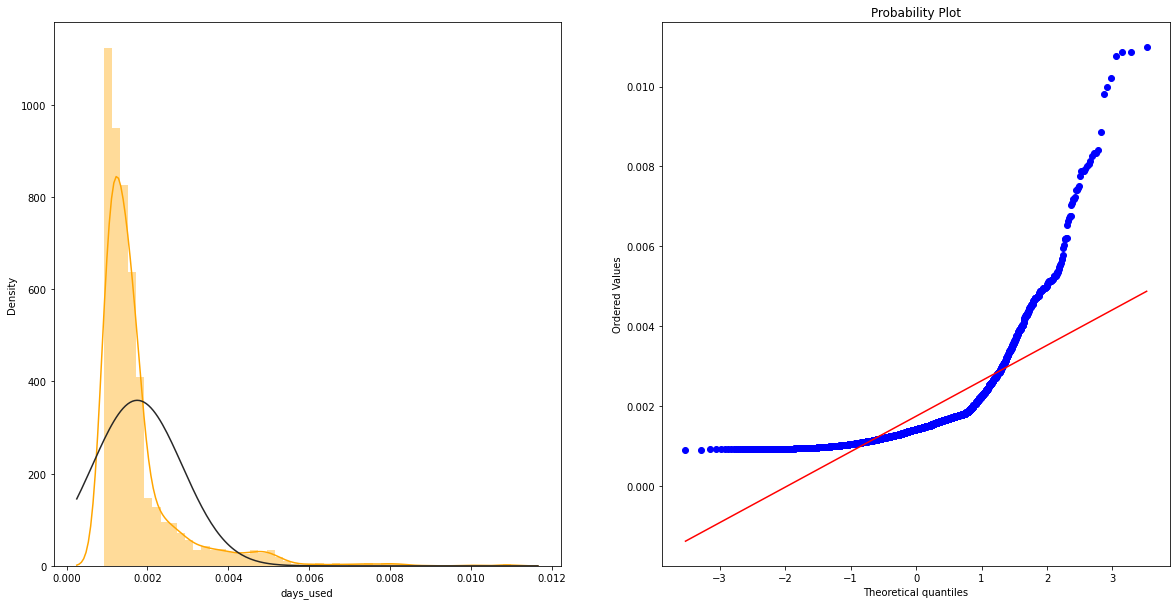

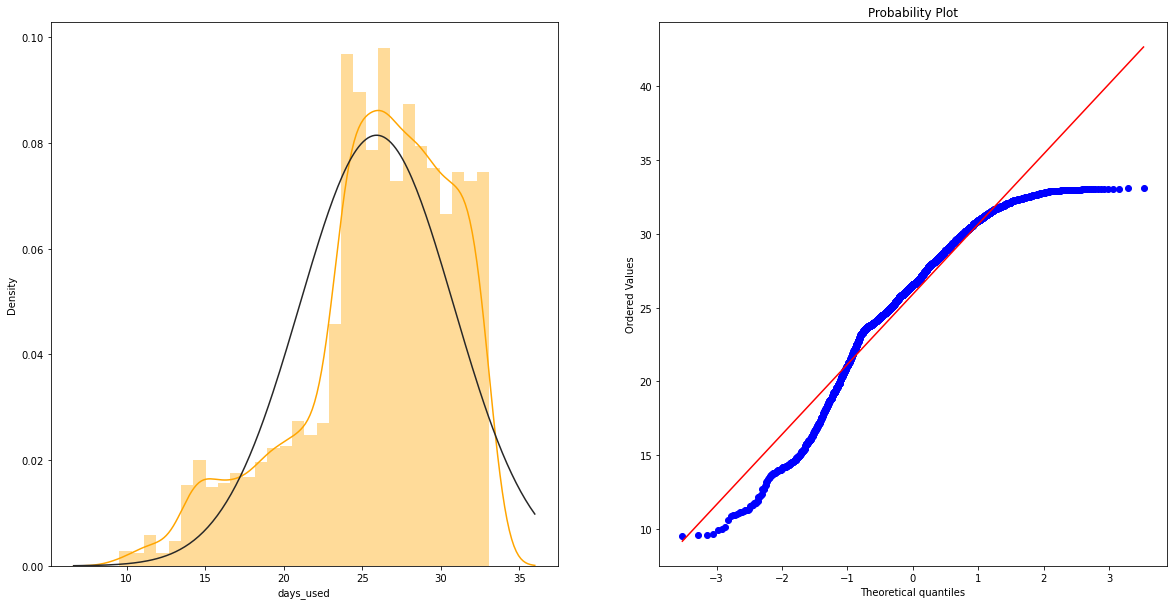

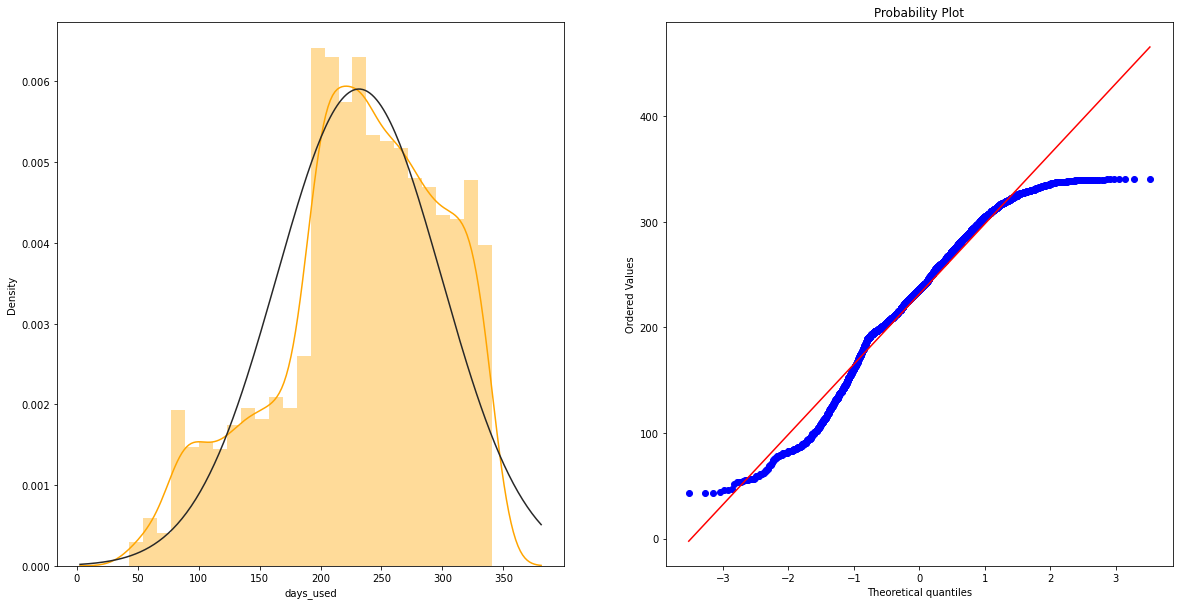

In [53]:
for x in transformations:
    trying_different_transformations('days_used',x)

# Applying transformations

In [54]:
def skweness_correction(columnName):    
    if columnName == 'front_camera_mp' or columnName == 'screen_size' or columnName == 'battery':
        data[columnName], temp_params = boxcox(
        data[columnName]+1)
    elif columnName == 'weight':
        data[columnName] = 1/data[columnName].replace([np.inf, -np.inf], 0)
    elif columnName =='rear_camera_mp':
        data[columnName] = data[columnName]**(1/2)
    print('''After Correcting''')
    (mu, sigma) = norm.fit(data[columnName])
    print("Mu after correcting {} : {}, Sigma after correcting {} : {}".format(
        columnName.upper(), mu, columnName.upper(), sigma))
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    sns.distplot(data[columnName], fit=norm, color="orange")
    plt.title(columnName.upper() +
              " Distplot After Skewness Correction", color="black")
    plt.subplot(1,2,2)
    stats.probplot(data[columnName], plot = plt)
    plt.show();

After Correcting
Mu after correcting SCREEN_SIZE : 3.5698404424676915, Sigma after correcting SCREEN_SIZE : 0.4545136324169383


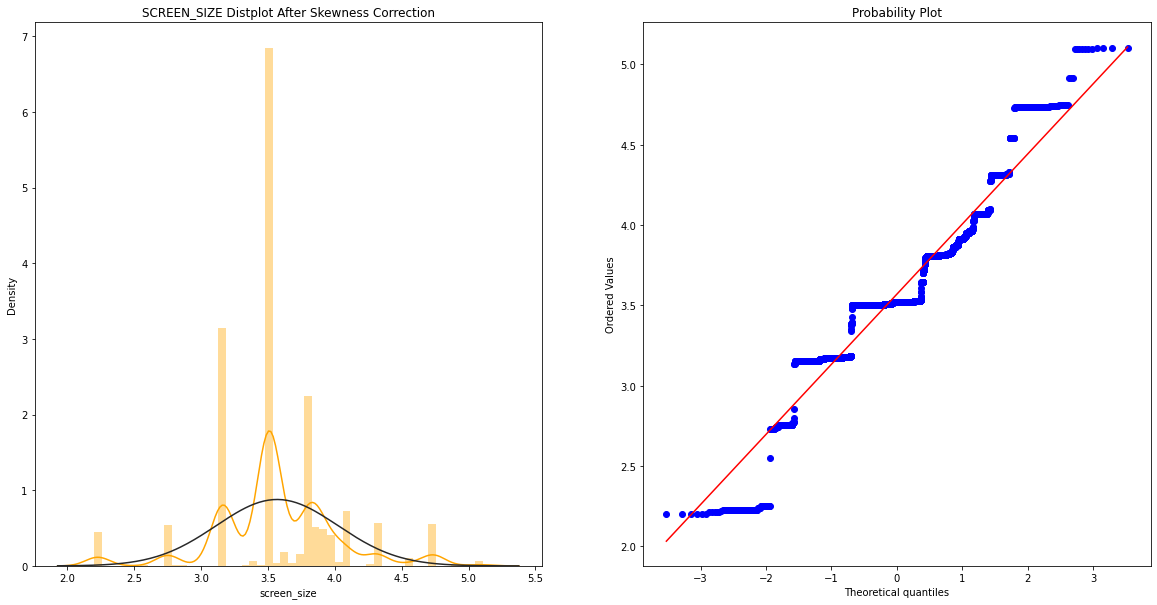

After Correcting
Mu after correcting REAR_CAMERA_MP : 2.9592967600910938, Sigma after correcting REAR_CAMERA_MP : 0.847889627462975


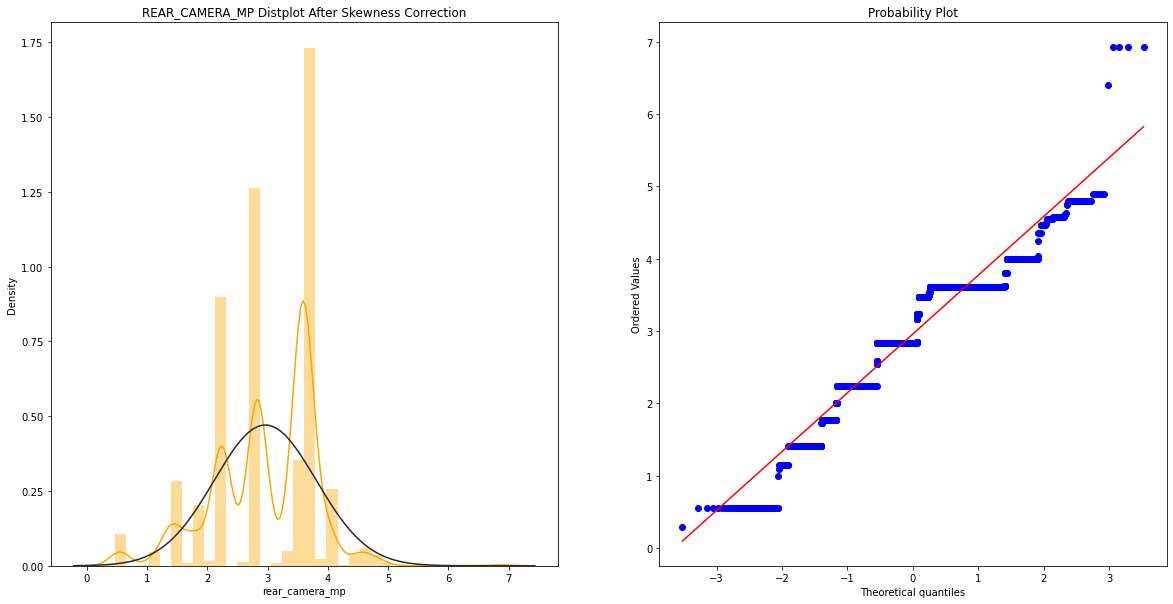

After Correcting
Mu after correcting FRONT_CAMERA_MP : 1.5268144858285813, Sigma after correcting FRONT_CAMERA_MP : 0.8193688139683319


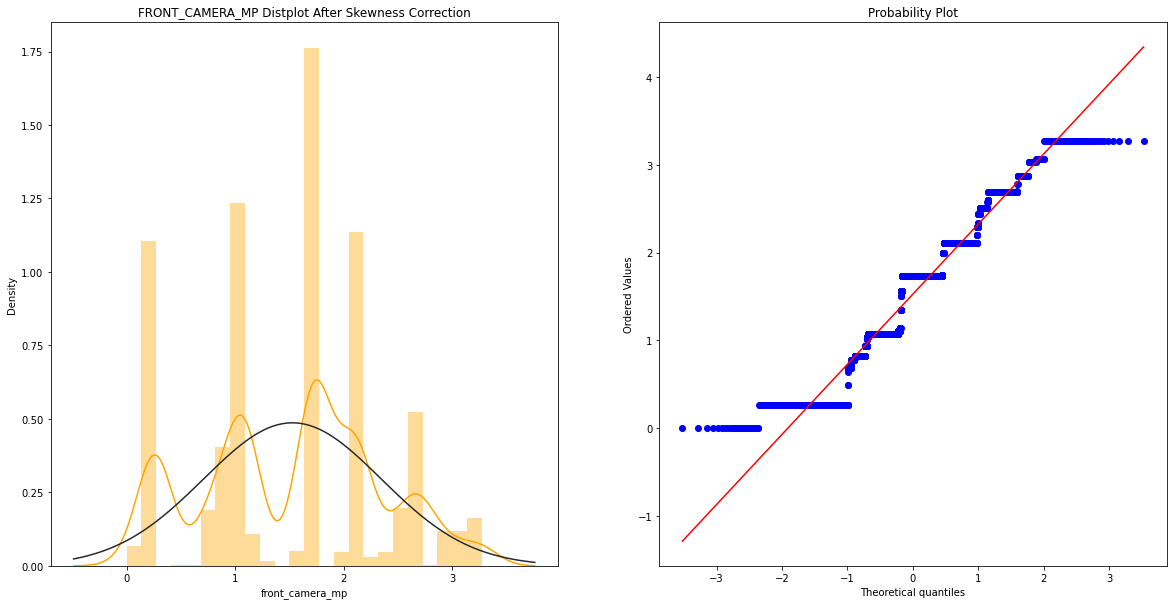

After Correcting
Mu after correcting BATTERY : 9.140952023574444, Sigma after correcting BATTERY : 0.5274073169353909


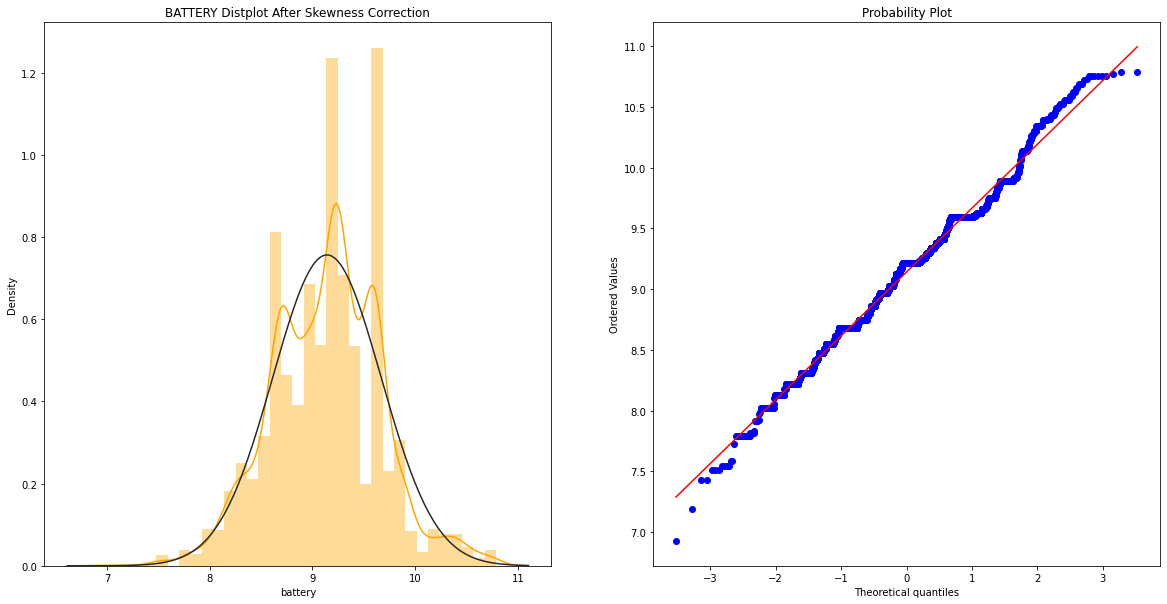

After Correcting
Mu after correcting WEIGHT : 0.006213180426972396, Sigma after correcting WEIGHT : 0.0017488702471315902


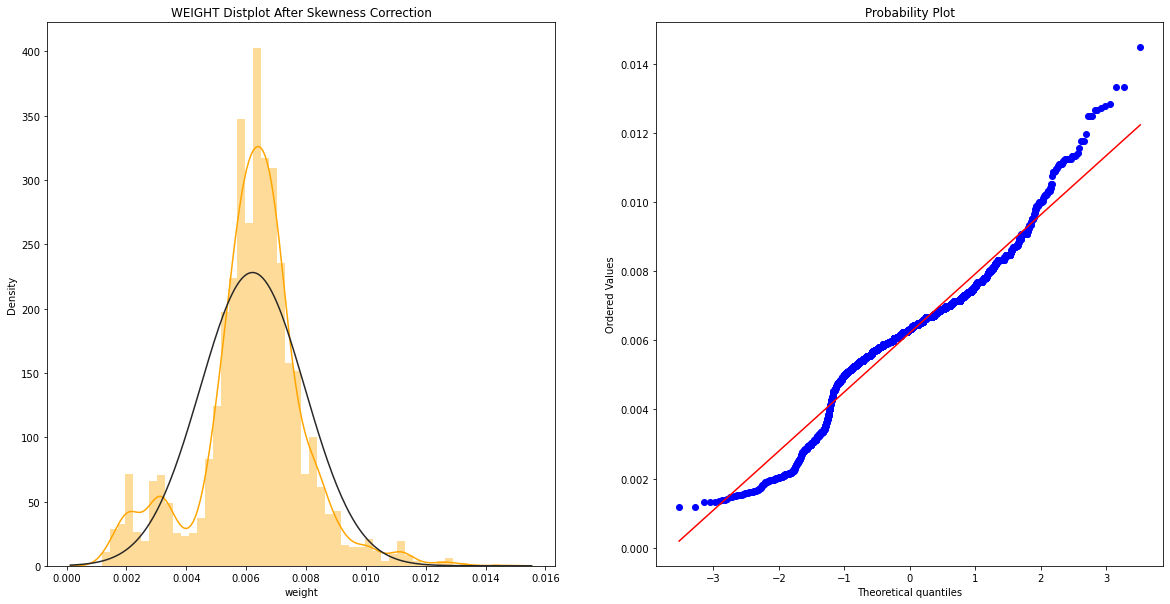

In [55]:
skewColumnList1 = ['screen_size','rear_camera_mp','front_camera_mp','battery','weight']
for columns in skewColumnList1:
    skweness_correction(columns)

# Dropping Outliers

In [56]:
len(detect_outliers(cols))

435

In [57]:
data = data.drop(detect_outliers(cols),axis = 0).reset_index(drop = True)

In [58]:
data.shape[0]

2818

# Encoding categorical features

In [59]:
data = data.drop(['os','device_brand'],axis=1)

In [60]:
data.head()

,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price,Device_Brand
0,3.720275,1,0,3.605551,1.731322,64.0,3.0,9.219591,0.006849,2020,127,4.307572,4.715100,4.683326
1,4.023023,1,1,3.605551,2.684077,128.0,8.0,9.687109,0.004695,2020,325,5.162097,5.519018,4.683326
2,3.960345,1,1,3.605551,2.106805,128.0,8.0,9.655799,0.004695,2020,162,5.111084,5.884631,4.683326
3,3.813117,1,0,3.605551,2.106805,64.0,3.0,9.888398,0.005405,2020,293,4.389995,4.947837,4.683326
4,3.911944,1,0,3.605551,2.106805,64.0,4.0,9.590960,0.005682,2020,223,4.413889,5.060694,4.683326


In [61]:
dummies_year = pd.get_dummies(data['release_year'],drop_first=True)
data = pd.concat([data,dummies_year],axis=1)
data = data.drop('release_year',axis=1)

In [62]:
data.head()

,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,days_used,normalized_used_price,normalized_new_price,Device_Brand,2014,2015,2016,2017,2018,2019,2020
0,3.720275,1,0,3.605551,1.731322,64.0,3.0,9.219591,0.006849,127,4.307572,4.715100,4.683326,0,0,0,0,0,0,1
1,4.023023,1,1,3.605551,2.684077,128.0,8.0,9.687109,0.004695,325,5.162097,5.519018,4.683326,0,0,0,0,0,0,1
2,3.960345,1,1,3.605551,2.106805,128.0,8.0,9.655799,0.004695,162,5.111084,5.884631,4.683326,0,0,0,0,0,0,1
3,3.813117,1,0,3.605551,2.106805,64.0,3.0,9.888398,0.005405,293,4.389995,4.947837,4.683326,0,0,0,0,0,0,1
4,3.911944,1,0,3.605551,2.106805,64.0,4.0,9.590960,0.005682,223,4.413889,5.060694,4.683326,0,0,0,0,0,0,1


In [63]:
Y = data['normalized_used_price']
X = data.loc[:, data.columns != 'normalized_used_price']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [65]:
X_train.head()

,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,days_used,normalized_new_price,Device_Brand,2014,2015,2016,2017,2018,2019,2020
206,3.815335,1,0,2.828427,2.684077,64.0,4.0,9.590960,0.005051,517,5.772655,4.322144,0,0,0,0,0,1,0
2037,3.171335,1,0,2.236068,1.075690,32.0,4.0,8.805266,0.006494,882,5.393628,4.510090,0,1,0,0,0,0,0
1824,3.502049,0,0,3.605551,1.075690,16.0,4.0,8.971906,0.007092,1089,5.473195,4.282206,1,0,0,0,0,0,0
2029,3.524854,1,0,4.000000,1.731322,32.0,4.0,9.232592,0.006623,1048,5.942537,4.510090,0,1,0,0,0,0,0
2441,3.518543,1,0,3.605551,1.731322,16.0,4.0,9.253988,0.005405,980,4.941857,4.630935,0,1,0,0,0,0,0


In [66]:
X_train.columns

Index([         'screen_size',                   '4g',                   '5g',
             'rear_camera_mp',      'front_camera_mp',      'internal_memory',
                        'ram',              'battery',               'weight',
                  'days_used', 'normalized_new_price',         'Device_Brand',
                         2014,                   2015,                   2016,
                         2017,                   2018,                   2019,
                         2020],
      dtype='object')

# Scaling features

In [67]:
sc=StandardScaler()
X_train.iloc[:,[0,3,4,5,6,7,8,9,10,11]]=sc.fit_transform(X_train.iloc[:,[0,3,4,5,6,7,8,9,10,11]])
X_test.iloc[:,[0,3,4,5,6,7,8,9,10,11]]=sc.fit_transform(X_test.iloc[:,[0,3,4,5,6,7,8,9,10,11]])

In [68]:
X_test.shape[0]

846

In [69]:
X_train.head()

,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,days_used,normalized_new_price,Device_Brand,2014,2015,2016,2017,2018,2019,2020
206,0.966499,1,0,-0.343085,1.322530,0.218023,-0.10769,1.097924,-1.026277,-0.724345,0.827879,-0.213414,0,0,0,0,0,1,0
2037,-1.463198,1,0,-1.117681,-0.661686,-0.248495,-0.10769,-0.768738,0.130485,0.793385,0.202005,0.478266,0,1,0,0,0,0,0
1824,-0.215474,0,0,0.673119,-0.661686,-0.481754,-0.10769,-0.372832,0.610418,1.654125,0.333391,-0.360393,1,0,0,0,0,0,0
2029,-0.129433,1,0,1.188919,0.147146,-0.248495,-0.10769,0.246509,0.233904,1.483641,1.108398,0.478266,0,1,0,0,0,0,0
2441,-0.153245,1,0,0.673119,0.147146,-0.481754,-0.10769,0.297343,-0.741776,1.200885,-0.543988,0.923002,0,1,0,0,0,0,0


# Linear Regression Model

In [70]:
linear_model = LinearRegression()
linear_model.fit(X_train,y_train)
X_train_Prediction = linear_model.predict(X_train)
print("MSE : ",mean_squared_error(y_train,X_train_Prediction))
print("R2 Score : ",r2_score(y_train,X_train_Prediction))
linear_model_score=r2_score(y_train,X_train_Prediction)
linear_model_ms=mean_squared_error(y_train,X_train_Prediction)

MSE :  0.04747644576021267
R2 Score :  0.8073472801706031


In [71]:
cross_linear = cross_val_score(linear_model,X_train,y_train,scoring="neg_mean_squared_error",cv=5)
mean_cross_linear = np.mean(cross_linear)
print(mean_cross_linear)
linear_model_cval=cross_val_score(linear_model,X_train,y_train,scoring="neg_mean_squared_error",cv=5)

-0.048845316982039935


# Ridge Regression Model

In [72]:
ridge_model = Ridge()
ridge_model.fit(X_train,y_train)
X_train_pred_ridge = ridge_model.predict(X_train)
print("MSE : ",mean_squared_error(y_train,X_train_pred_ridge))
print("R2 Score : ",r2_score(y_train,X_train_pred_ridge))
ridge_model_score=r2_score(y_train,X_train_pred_ridge)
ridge_model_ms=mean_squared_error(y_train,X_train_pred_ridge)

MSE :  0.04747662316276385
R2 Score :  0.807346560296075


In [73]:
cross_ridge = cross_val_score(ridge_model,X_train,y_train,scoring="neg_mean_squared_error",cv=5)
mean_cross_ridge = np.mean(cross_ridge)
print(mean_cross_ridge)
ridge_model_cval=cross_val_score(ridge_model,X_train,y_train,scoring="neg_mean_squared_error",cv=5)

-0.04883251666252693


# SVM Regressor

In [74]:
svmreg_model = SVR()
svmreg_model.fit(X_train,y_train)
X_train_pred_svmreg = svmreg_model.predict(X_train)
print("MSE : ",mean_squared_error(y_train,X_train_pred_svmreg))
print("R2 Score : ",r2_score(y_train,X_train_pred_svmreg))
svm_model_score=r2_score(y_train,X_train_pred_svmreg)
svm_model_ms=mean_squared_error(y_train,X_train_pred_svmreg)

MSE :  0.033477873862656556
R2 Score :  0.8641515102810979


In [75]:
cross_svmreg = cross_val_score(svmreg_model,X_train,y_train,scoring="neg_mean_squared_error",cv=5)
mean_cross_svmreg = np.mean(cross_svmreg)
print(mean_cross_svmreg)
svm_model_cval=cross_val_score(svmreg_model,X_train,y_train,scoring="neg_mean_squared_error",cv=5)

-0.05471531752776929


# DecisionTree Regressor

In [76]:
dtree_model = DecisionTreeRegressor(max_depth=10)
dtree_model.fit(X_train,y_train)
X_train_pred_dtree = dtree_model.predict(X_train)
print("MSE : ",mean_squared_error(y_train,X_train_pred_dtree))
print("R2 Score : ",r2_score(y_train,X_train_pred_dtree))
dtree_model_score=r2_score(y_train,X_train_pred_dtree)
dtree_model_ms=mean_squared_error(y_train,X_train_pred_dtree)

MSE :  0.01694584609269659
R2 Score :  0.9312361469504887


In [77]:
cross_dtree = cross_val_score(dtree_model,X_train,y_train,scoring="neg_mean_squared_error",cv=5)
mean_cross_dtree = np.mean(cross_dtree)
print(mean_cross_dtree)
dtree_model_cval=cross_val_score(dtree_model,X_train,y_train,scoring="neg_mean_squared_error",cv=5)

-0.08128801260790038


# RandomForest Regressor

In [78]:
rfr_model = RandomForestRegressor()
rfr_model.fit(X_train,y_train)
X_train_pred_rfr = rfr_model.predict(X_train)
print("MSE : ",mean_squared_error(y_train,X_train_pred_rfr))
print("R2 Score : ",r2_score(y_train,X_train_pred_rfr))
rfr_model_score=r2_score(y_train,X_train_pred_rfr)
rfr_model_ms=mean_squared_error(y_train,X_train_pred_rfr)

MSE :  0.007028133606688295
R2 Score :  0.9714808252182267


In [79]:
cross_rfr = cross_val_score(rfr_model,X_train,y_train,scoring="neg_mean_squared_error",cv=5)
mean_cross_rfr = np.mean(cross_rfr)
print(mean_cross_rfr)
rfr_model_cval=cross_val_score(rfr_model,X_train,y_train,scoring="neg_mean_squared_error",cv=5)

-0.05034258141831065


In [80]:
X_test_pred_rfr = rfr_model.predict(X_test)
print("MSE : ",mean_squared_error(y_test,X_test_pred_rfr))
print("R2 Score : ",r2_score(y_test,X_test_pred_rfr))

MSE :  0.051959748775287376
R2 Score :  0.7854612203985784


# Comparing R2 score of models

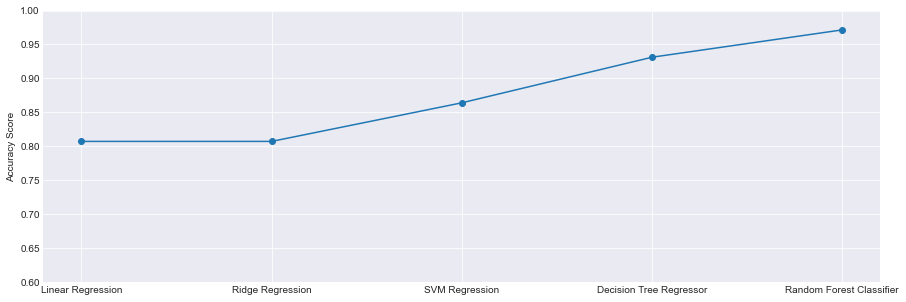

In [81]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(15, 5))
models = ['Linear Regression', 'Ridge Regression','SVM Regression','Decision Tree Regressor',"Random Forest Classifier"]
test_accuracy = [linear_model_score, ridge_model_score,svm_model_score,dtree_model_score,rfr_model_score]
plt.plot(models, test_accuracy, '-o')
plt.ylim(0.60, 1.0)
plt.ylabel("Accuracy Score")
plt.show();

# Comparing Mean square error of the models

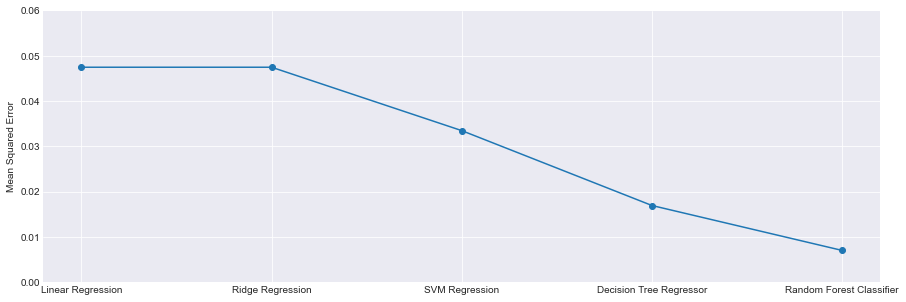

In [82]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(15, 5))
models = ['Linear Regression', 'Ridge Regression','SVM Regression','Decision Tree Regressor',"Random Forest Classifier"]
test_accuracy = [linear_model_ms, ridge_model_ms,svm_model_ms,dtree_model_ms,rfr_model_ms]
plt.plot(models, test_accuracy, '-o')
plt.ylim(0.0, 0.06)
plt.ylabel("Mean Squared Error")
plt.show();

# Conclusion

## Random Forest performs the best for the given problem

In [83]:
pk.dump(rfr_model,open("Price_Predictor.pkl",'wb'))

In [84]:
pk.dump(sc,open("Scaler.pkl",'wb'))